In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
import catboost as catb

In [2]:
import warnings
warnings.simplefilter('ignore')

## Пути к директориям и файлам

In [3]:
dataset_path = "train.csv"
prep_dataset_path = "test.csv"

In [4]:
df = pd.read_csv(dataset_path)
test = pd.read_csv(prep_dataset_path)
train = pd.read_csv(dataset_path)

## Описание данных

#####    Home Ownership - домовладение
#####    Annual Income - годовой доход
#####    Years in current job - количество лет на текущем месте работы
#####    Tax Liens - налоговые обременения
#####    Number of Open Accounts - количество открытых счетов
#####    Years of Credit History - количество лет кредитной истории
#####    Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
#####    Number of Credit Problems - количество проблем с кредитом
#####    Months since last delinquent - количество месяцев с последней просрочки платежа
#####    Bankruptcies - банкротства
#####    Purpose - цель кредита
#####    Term - срок кредита
#####    Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
#####    Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
#####    Monthly Debt - ежемесячный долг
#####    Credit Score - баллы кредитного рейтинга
#####    Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


## Приведение типов

**Years in current job**

перевод в вещественный признак

In [5]:
train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [6]:
def years_in_current_job_to_cat(data):
    data['Years in current job'] = data['Years in current job'].map({'< 1 year': 0,
                                                                 '1 year': 1,
                                                                 '2 years': 2,
                                                                 '3 years': 3,
                                                                 '4 years': 4,
                                                                 '5 years': 5,
                                                                 '6 years': 6,
                                                                 '7 years': 7,
                                                                 '8 years': 8,
                                                                 '9 years': 9,
                                                                 '10+ years': 10
                                                                })
    return data

In [7]:
df = years_in_current_job_to_cat(df)
train = years_in_current_job_to_cat(train)
test = years_in_current_job_to_cat(test)

In [8]:
df.shape

(7500, 17)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

## Обзор данных

### Обзор целевой переменной

In [10]:
df["Credit Default"].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Обзор количественных признаков

In [11]:
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7129.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,5.880348,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,3.620092,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


наблюдаются аномалии в следующих признаках:

- Maximum Open Credit
- Current Loan Amount
- Credit Score


### Обзор номинативных признаков

- Home Ownership - домовладение
- Years in current job - количество лет на текущем месте работы
- Purpose - цель кредита
- Term - срок кредита

In [12]:
for cat_colname in df.select_dtypes(include="object").columns:
    print(f'{cat_colname}' + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
****************************************************************************************************



- изучить объединение в Home Ownership;
- изучить объединение в Purpose;
- изучить объединение в Years in Current job;

## Обработка данных

отсутствует часть данных в:
    
    - Annual income;
    - Years in current job;
    - Month since last delinquent;
    - Bankruptcies;
    - Credit Score

### Заполнение пропусков

**Annual Income**

In [13]:
annual_income_median = df["Annual Income"].median()

def annual_income_fillna(data):
    data['Annual Income NaN'] = False
    data.loc[data["Annual Income"].isna(), "Annual Income NaN"] = True
    data.loc[data["Annual Income"].isna(), "Annual Income"] =  annual_income_median # замена пропусков годового дохода на медиану
    return data

df = annual_income_fillna(df)
train = annual_income_fillna(train)
test = annual_income_fillna(test)

**Years in current job**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7129 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [15]:
years_in_current_job_mode = train["Years in current job"].mode()[0]

In [16]:
years_in_current_job_mode = train["Years in current job"].mode()[0]

def years_in_current_job_fillna(data):
    data['Years in current job NaN'] = False
    data.loc[data["Years in current job"].isna(), "Years in current job NaN"] = True
    data.loc[data["Years in current job"].isna(), "Years in current job"] = years_in_current_job_mode
    return data

df = years_in_current_job_fillna(df)
train = years_in_current_job_fillna(train)
test = years_in_current_job_fillna(test)

**Months since last delinquent**

In [17]:
months_since_last_delinquent_median = train["Months since last delinquent"].median()

def months_since_last_delinquent_fillna(data):
    data['Months since last delinquent NaN'] = False
    data.loc[data["Months since last delinquent"].isna(), "Months since last delinquent NaN"] = True
    data.loc[data["Months since last delinquent"].isna(), "Months since last delinquent"] = months_since_last_delinquent_median
    return data


df = months_since_last_delinquent_fillna(df)
train = months_since_last_delinquent_fillna(train)
test = months_since_last_delinquent_fillna(test)

**Bankruptcies**

In [18]:
bankruptcies_median = train["Bankruptcies"].median()

def bankruptcies_fillna(data):
    data.loc[data["Bankruptcies"].isna(), "Bankruptcies"] = bankruptcies_median
    return data


df = bankruptcies_fillna(df)
train = bankruptcies_fillna(train)
test = bankruptcies_fillna(test)

**Credit Score**

In [19]:
credit_score_median = train['Credit Score'].median()

def credit_score_fillna(data):
    data['Credit Score NaN'] = False
    data.loc[data['Credit Score'].isna(), 'Credit Score NaN'] = True
    data.loc[data["Credit Score"].isna(), "Credit Score"] = credit_score_median
    return data

df = credit_score_fillna(df)
train = credit_score_fillna(train)
test = credit_score_fillna(test)

*Проверка заполененности*

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Home Ownership                    7500 non-null   object 
 1   Annual Income                     7500 non-null   float64
 2   Years in current job              7500 non-null   float64
 3   Tax Liens                         7500 non-null   float64
 4   Number of Open Accounts           7500 non-null   float64
 5   Years of Credit History           7500 non-null   float64
 6   Maximum Open Credit               7500 non-null   float64
 7   Number of Credit Problems         7500 non-null   float64
 8   Months since last delinquent      7500 non-null   float64
 9   Bankruptcies                      7500 non-null   float64
 10  Purpose                           7500 non-null   object 
 11  Term                              7500 non-null   object 
 12  Curren

### Обработка выбросов

In [21]:
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.325286e+06,6.084133,0.030133,11.130933,18.317467,9.451537e+05,0.170000,33.227467,0.116933,1.187318e+07,2.898332e+05,18314.454133,1063.877333,0.281733
std,7.567551e+05,3.640717,0.271604,4.908924,7.041946,1.602622e+07,0.498598,14.703950,0.346904,3.192612e+07,3.178714e+05,11926.764673,1438.335832,0.449874
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,32.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000
max,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Maximum Open Credit**

<AxesSubplot:xlabel='Maximum Open Credit'>

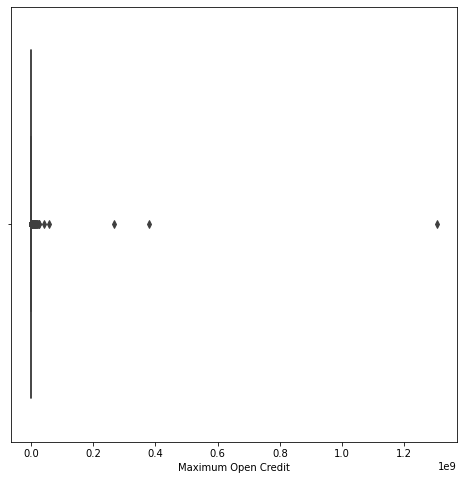

In [22]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=df,
           x="Maximum Open Credit")

<AxesSubplot:>

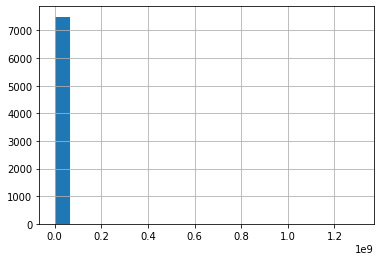

In [23]:
df['Maximum Open Credit'].hist(bins=20)

In [24]:
maximum_open_credit_max = train["Maximum Open Credit"].quantile(0.99)

def maximum_open_credit(data):
    data['Maximum Open Credit outlier'] = False
    data.loc[data["Maximum Open Credit"] > 2 * 10 ** 8, 'Maximum Open Credit outlier'] = True
    data.loc[data["Maximum Open Credit"] > 2 * 10 ** 8, "Maximum Open Credit"] = maximum_open_credit_max
    return data

df = maximum_open_credit(df)
train = maximum_open_credit(train)
test = maximum_open_credit(test)

<AxesSubplot:xlabel='Maximum Open Credit'>

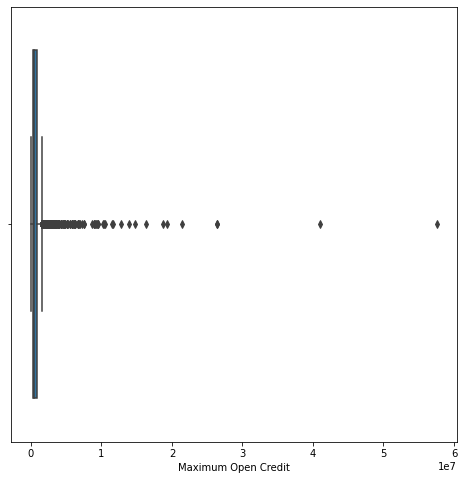

In [25]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=df,
           x="Maximum Open Credit")

**Current Loan Amount**

<AxesSubplot:xlabel='Current Loan Amount', ylabel='Density'>

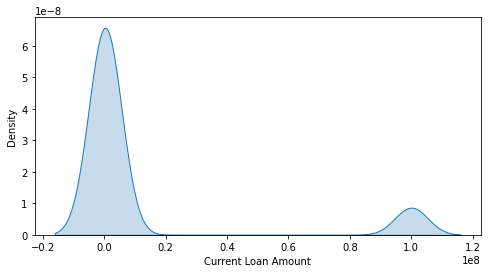

In [26]:
plt.figure(figsize=(8, 4))
sns.kdeplot(x=df["Current Loan Amount"], shade=True)

In [27]:
current_loan_median = train["Current Loan Amount"].median()

def current_loan_amount(data):
    data['Current Loan Amount outlier'] = False
    data.loc[data["Current Loan Amount"] > 0.2 * 10 ** 8, 'Current Loan Amount outlier'] = True
    data.loc[data["Current Loan Amount"] > 0.2 * 10 ** 8, "Current Loan Amount"] = current_loan_median
    return(data)


df = current_loan_amount(df)
train = current_loan_amount(train)
test = current_loan_amount(test)

<AxesSubplot:xlabel='Current Loan Amount', ylabel='Density'>

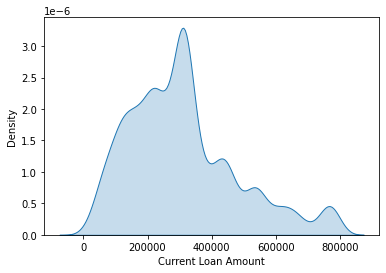

In [28]:
sns.kdeplot(data=df["Current Loan Amount"], shade=True)

**Credit Score**

<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

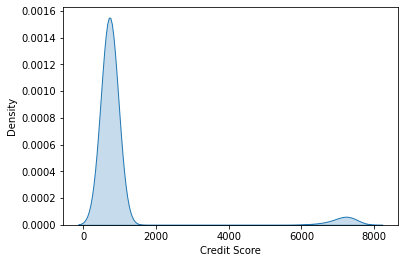

In [29]:
sns.kdeplot(x=df["Credit Score"], shade=True)

In [30]:
def credit_score(data):
    data['Credit Score outlier'] = False
    data.loc[data['Credit Score'] > 1500, 'Credit Score outlier'] = True
    data.loc[data["Credit Score"] > 1500, "Credit Score"] = data.loc[data["Credit Score"] > 1500, "Credit Score"] / 10
    return data


df = credit_score(df)
train = credit_score(train)
test = credit_score(test)

<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

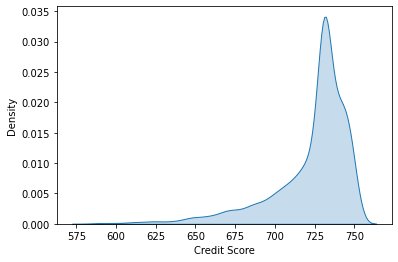

In [31]:
sns.kdeplot(x=df["Credit Score"], shade=True)

**Number of credit problems and Tax Liens**

<AxesSubplot:xlabel='Number of Credit Problems', ylabel='Credit Default'>

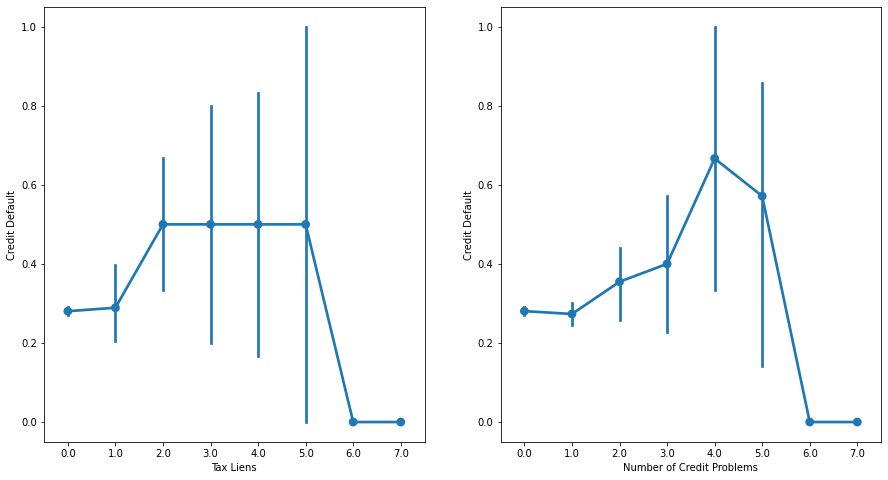

In [32]:
plt.figure(figsize=(15, 8))
plt.subplot(121)
sns.pointplot(data=df, x='Tax Liens', y='Credit Default')
plt.subplot(122)
sns.pointplot(data=df, x='Number of Credit Problems', y='Credit Default')

In [33]:
df.loc[df['Number of Credit Problems'] >= 5, ['Tax Liens', 'Credit Default']].count()

Tax Liens         12
Credit Default    12
dtype: int64

In [34]:
df.loc[df['Tax Liens'] >= 5, ['Tax Liens', 'Credit Default']].count()

Tax Liens         5
Credit Default    5
dtype: int64

In [35]:
def drop_number_of_credit_problems(data):
    data = data.drop(index=data.loc[data['Number of Credit Problems'] >= 5].index)
    return data

df = drop_number_of_credit_problems(df)
train = drop_number_of_credit_problems(train)
test = drop_number_of_credit_problems(test)

### Выделение целевой переменной и групп признаков

In [36]:
df_base = pd.read_csv("train.csv")

In [37]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).to_list()

In [38]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [39]:
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [40]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

**Корреляция с базовыми признаками**

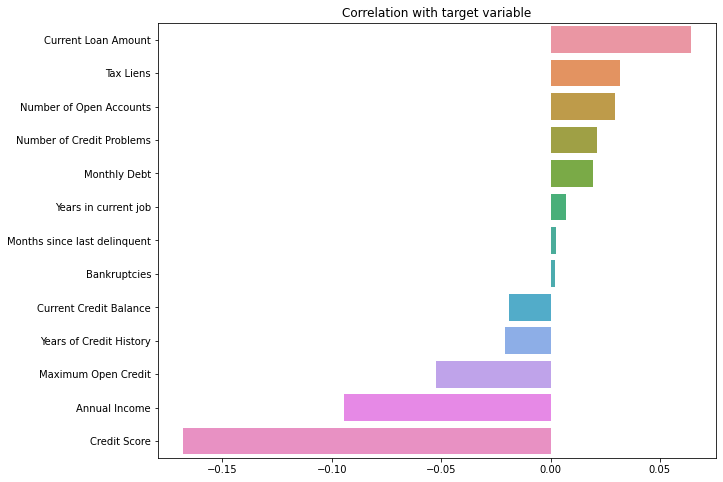

In [41]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Оценка "Credit Score" в разрезе целевой переменной**

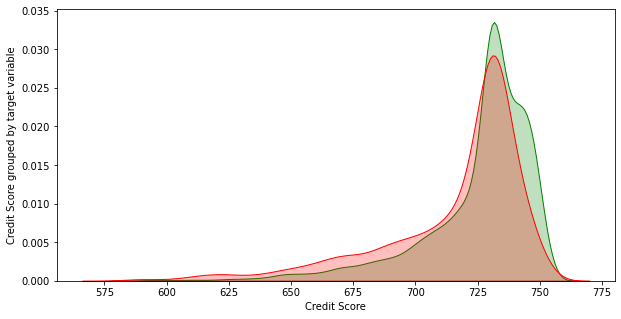

In [42]:
credit_score_with_target = df[['Credit Score', TARGET_NAME]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[TARGET_NAME] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.ylabel('Credit Score grouped by target variable')
plt.show()

группы имеют различные распределения, возможно существует некая функциональная зависимость

**Гипотеза**
- Н0 - средние значения в двух независимых выборках равны
- Н1 - средние значения в двух независмых выборках различаются
- Критерий: критерий Стьюдента (t-тест) и его аналоги
- Уровень значимости: 0.05

In [43]:
stats.shapiro(credit_score)

ShapiroResult(statistic=0.8042163848876953, pvalue=0.0)

при проведении теста Шапиро-Уилка выяснилось, что распределение признака не является нормальным: p-value < 0.05

Для достоверности произведенм визуальную оценку распределения признака, а также построим QQ-график

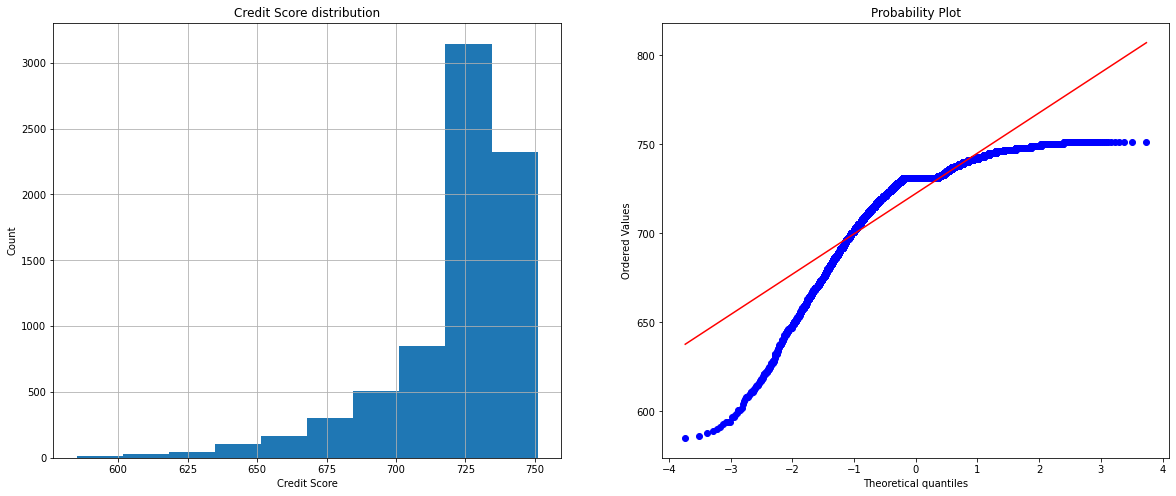

In [44]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score.hist()

plt.subplot(122)
stats.probplot(credit_score, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает, что распределение признака "Credit Score" не является нормальным, следовательно критерий t-Стьюдента использовать не можем.

Оценим эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни

In [45]:
stats.mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=6927941.0, pvalue=6.550068419806835e-51)

Согласно значению p-value мы видим, что равность мат. ожиданий отвергается p-value < 0.05.

Проверим равность мат. ожиданий согласно построению доверительных интервалов.

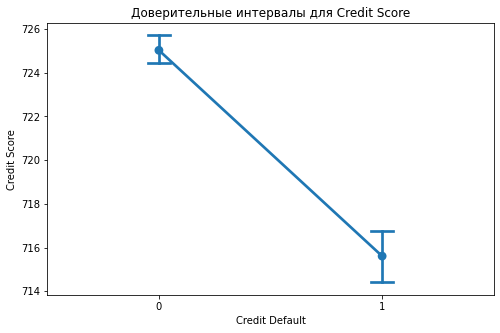

In [46]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target, capsize=.1)

plt.title('Доверительные интервалы для Credit Score')
plt.show()

Данный признак можно использовать в модели

### Матрица корреляций

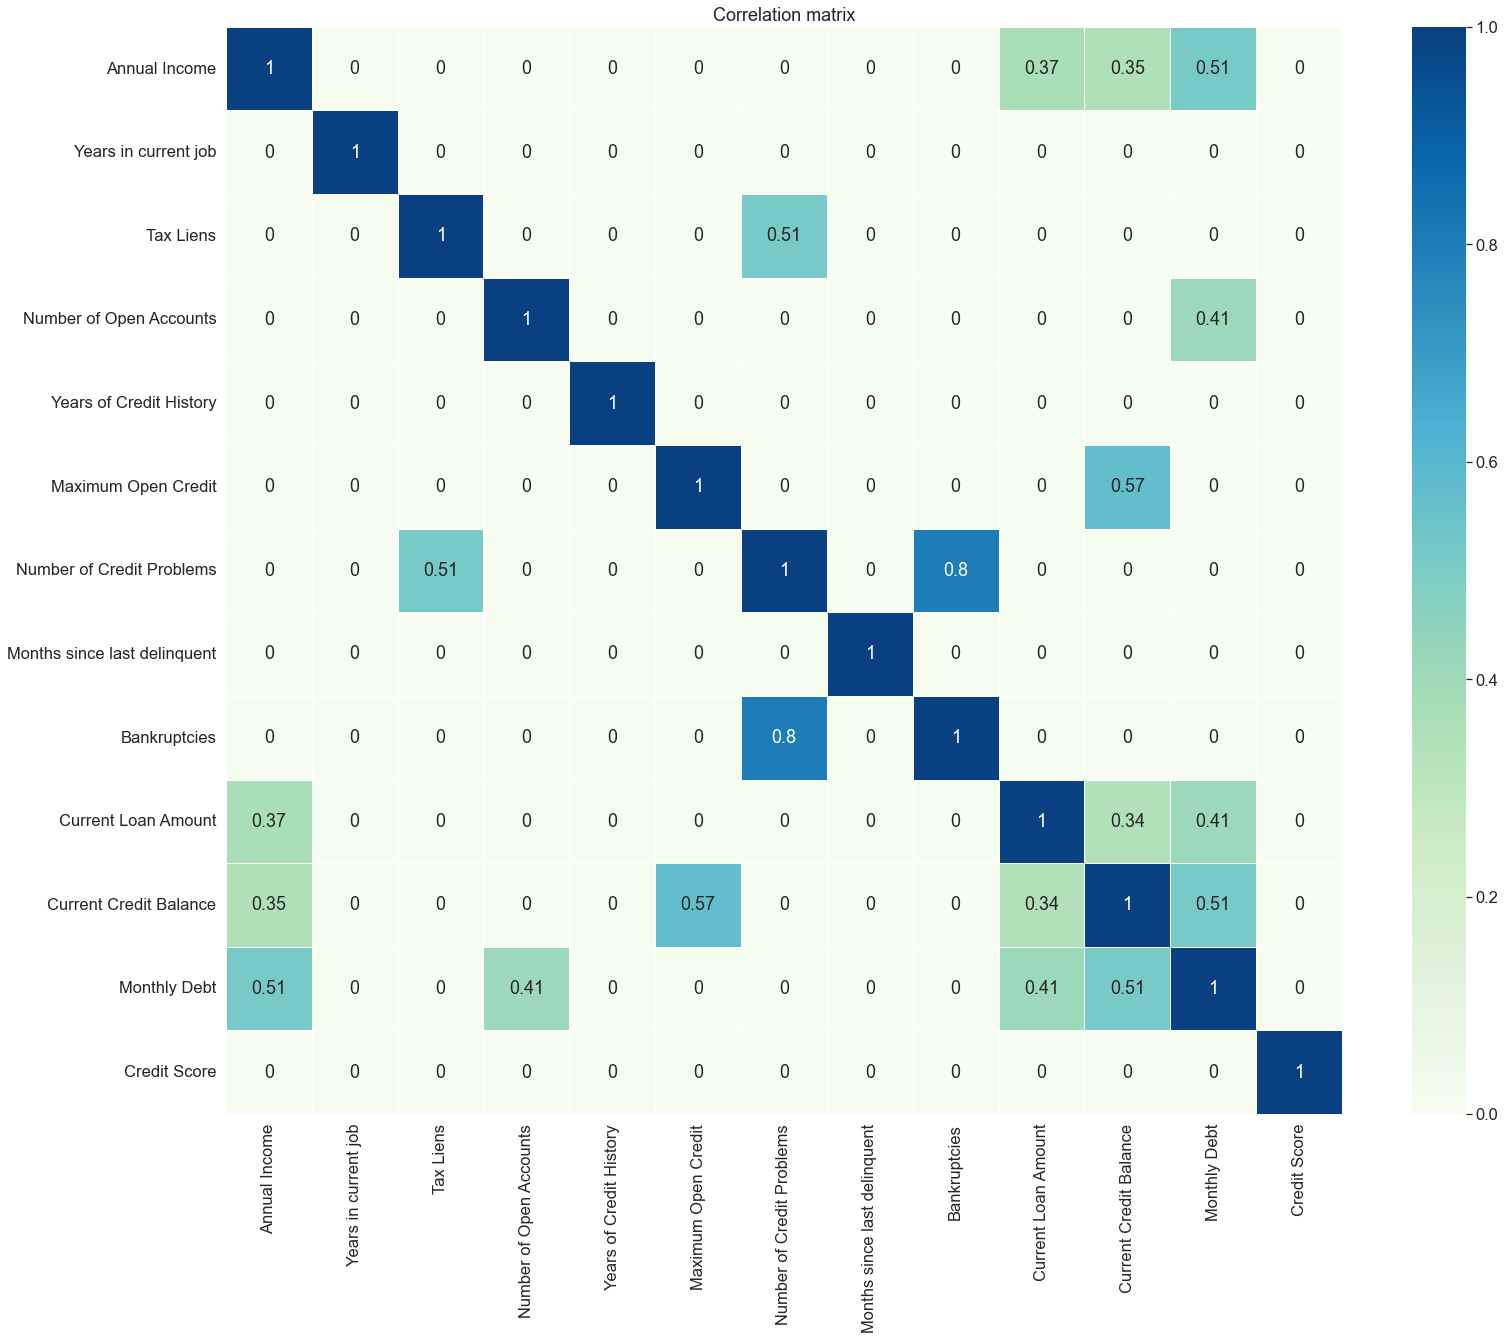

In [47]:
plt.figure(figsize=(25, 20))

sns.set(font_scale=1.5)

corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [48]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Annual Income NaN',
       'Years in current job NaN', 'Months since last delinquent NaN',
       'Credit Score NaN', 'Maximum Open Credit outlier',
       'Current Loan Amount outlier', 'Credit Score outlier'],
      dtype='object')

In [49]:
df[TARGET_NAME].value_counts()

0    5379
1    2109
Name: Credit Default, dtype: int64

**Проверка распределений вещественных признаков на трейне и тесте**

Annual Income
MannwhitneyuResult(statistic=9317302.0, pvalue=0.8704727142302158)


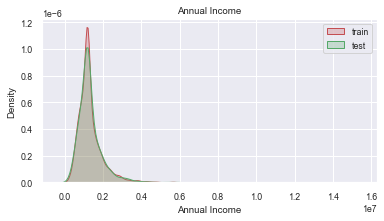

Tax Liens
MannwhitneyuResult(statistic=9303179.0, pvalue=0.22660690349952328)


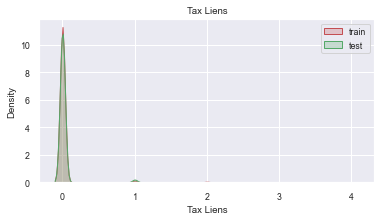

Number of Open Accounts
MannwhitneyuResult(statistic=9237785.0, pvalue=0.4223856022298359)


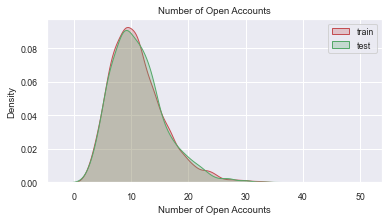

Years of Credit History
MannwhitneyuResult(statistic=9372427.5, pvalue=0.7795308240414434)


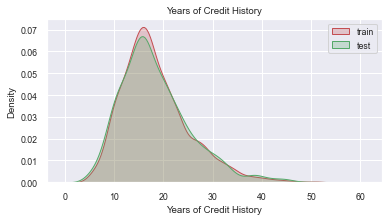

Maximum Open Credit
MannwhitneyuResult(statistic=9291447.0, pvalue=0.7115602432712453)


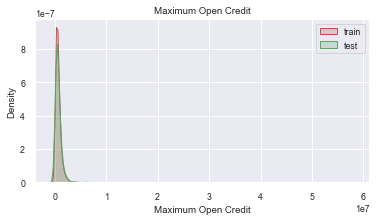

Number of Credit Problems
MannwhitneyuResult(statistic=9424524.0, pvalue=0.23720119599573275)


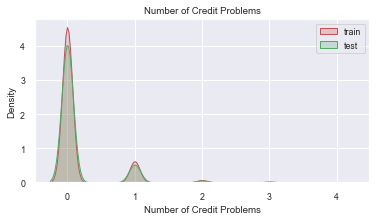

Months since last delinquent
MannwhitneyuResult(statistic=9502193.5, pvalue=0.14773688137221774)


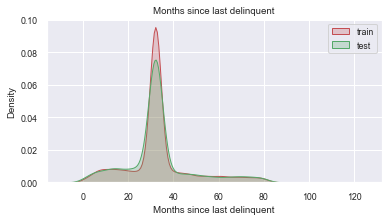

Bankruptcies
MannwhitneyuResult(statistic=9457504.0, pvalue=0.07182565829976247)


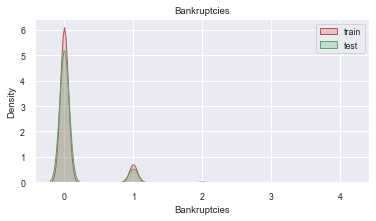

Current Loan Amount
MannwhitneyuResult(statistic=9184083.5, pvalue=0.21790969948768146)


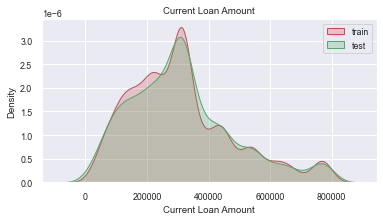

Current Credit Balance
MannwhitneyuResult(statistic=9370143.5, pvalue=0.793628864649901)


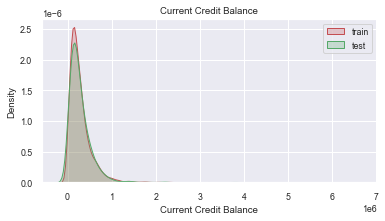

Monthly Debt
MannwhitneyuResult(statistic=9242108.0, pvalue=0.443913747640186)


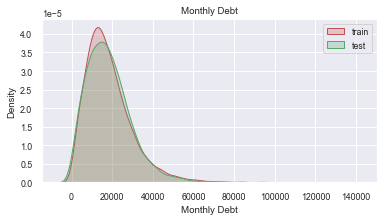

Credit Score
MannwhitneyuResult(statistic=9491461.5, pvalue=0.21433399888147597)


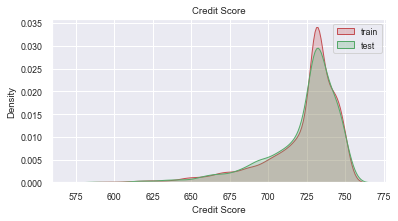

In [50]:

for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=(6, 3))
    sns.set(font_scale=0.8)
    sns.kdeplot(train[col], shade=True, label='train', color='r')
    sns.kdeplot(test[col], shade=True, label='test', color='g')
    print(col)
    print(stats.mannwhitneyu(train[col], test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

При сравнении мат. ожиданий признаков между train и test больших отклонений (pvalue < 0.05) не выявлено.

**Проверка распределений категориальных признаков на трейне и тесте**

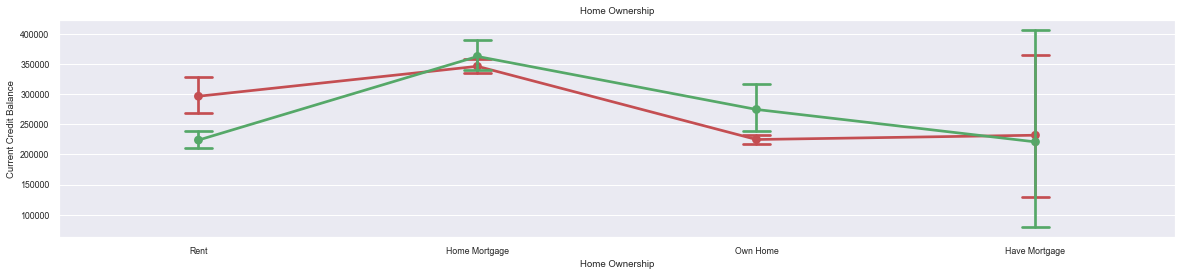

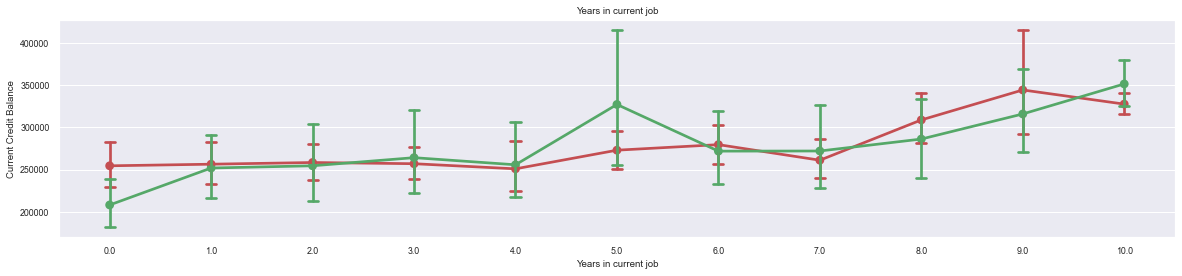

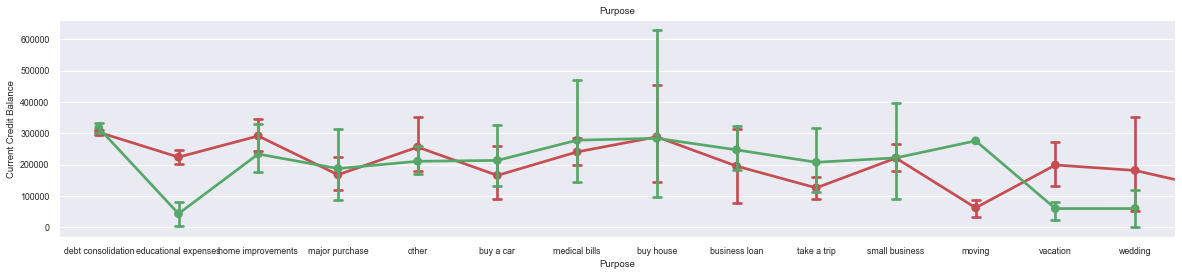

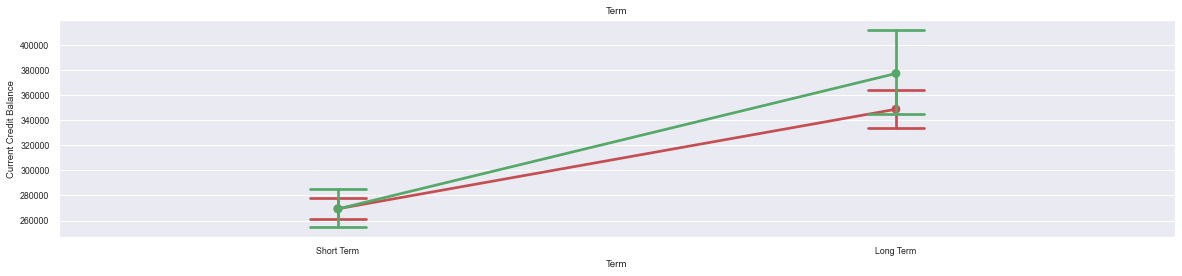

In [51]:
num_feature = 'Current Credit Balance'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=(20, 4))
    sns.pointplot(x=col, y=num_feature, data=train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

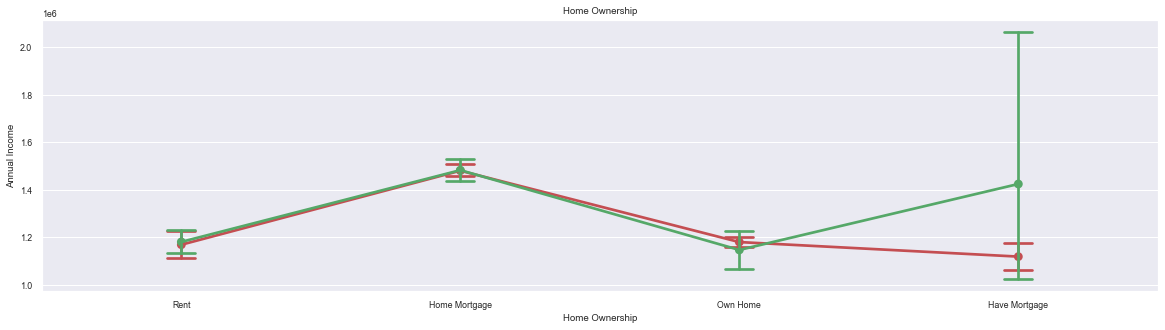

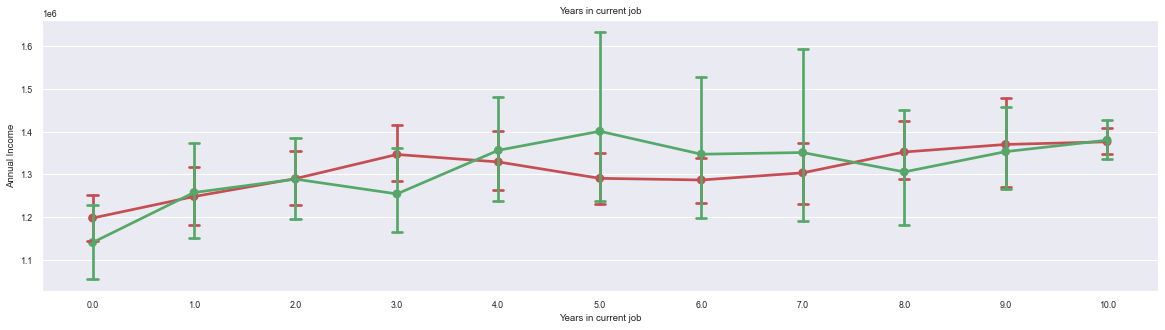

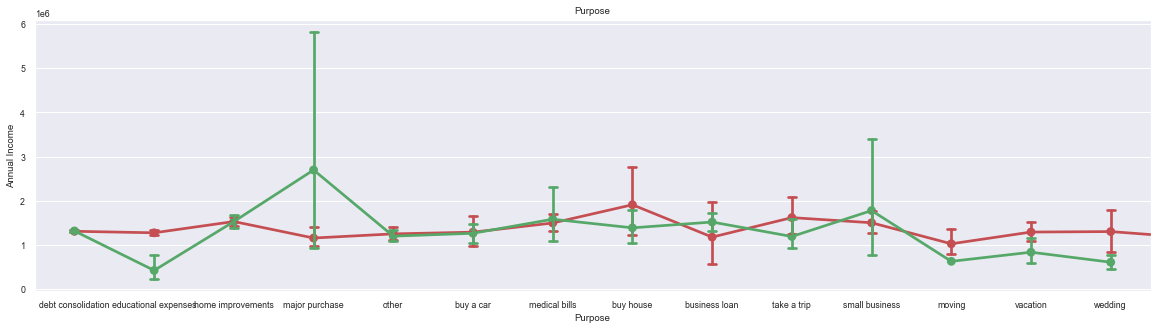

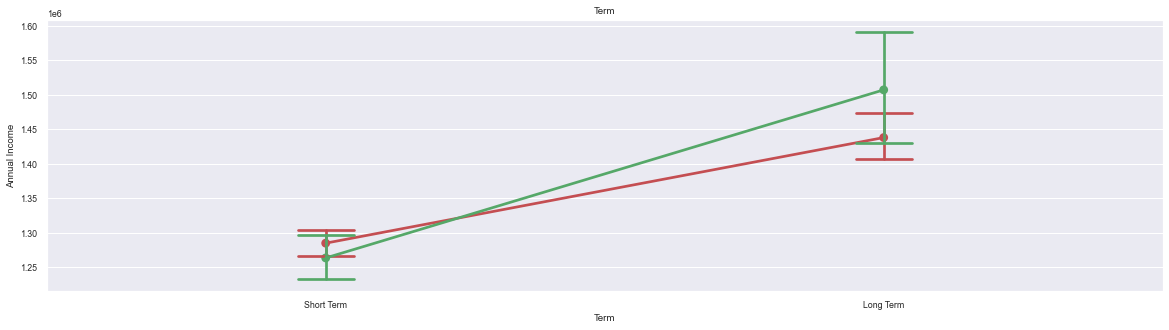

In [52]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=(20, 5))
    sns.pointplot(x=col, y=num_feature, data=train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

In [53]:
df['Purpose'].value_counts()

debt consolidation      5937
other                    664
home improvements        412
business loan            128
buy a car                 96
medical bills             70
major purchase            39
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   7
renewable energy           2
Name: Purpose, dtype: int64

В признаке 'Purpose' есть признаки, в которых сильно отличаются значения трэйна от теста 'moving', 'renewable energy'

In [54]:
def del_columns_purpose(data):
    data = data.drop(index=data.loc[data['Purpose'].isin(['moving', 'renewable energy', 'educational expenses'])].index)
    return data

df = del_columns_purpose(df)
train = del_columns_purpose(train)
test = del_columns_purpose(test)

## Сокращение количества значений в признаках

**Home Ownership**

In [55]:
df['Home Ownership'].value_counts()

Home Mortgage    3627
Rent             3186
Own Home          640
Have Mortgage      12
Name: Home Ownership, dtype: int64

рассмотрим возможность объединение Home Mortgage и Have Mortgage

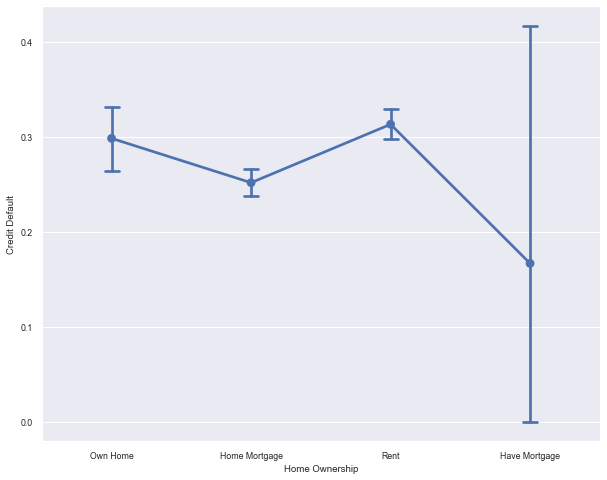

In [56]:
plt.figure(figsize=(10, 8))

sns.pointplot(x="Home Ownership", y="Credit Default", data=df, capsize=.1)

plt.show()

на графике доверительных интервалов однозначного ответа не видно, проверим статистическую гипотезу о согласованности частот методом Хи-квадрат.

- H0 - частоты согласованы
- H1 - частоты не согласованы

In [57]:
df["Id"] = df.index

Home_Ownership_and_target = df.loc[df["Home Ownership"].isin(["Have Mortgage", "Home Mortgage"]), \
                                   ["Id", "Home Ownership", "Credit Default"]]

In [58]:
table = Home_Ownership_and_target.pivot_table(values="Id", index="Home Ownership", columns="Credit Default", aggfunc="count")
table

Credit Default,0,1
Home Ownership,,
Have Mortgage,10,2
Home Mortgage,2714,913


In [59]:
chi2, p, _, _ = stats.chi2_contingency(table)
p

0.7302565181534185

Н0 верна, значит можно объединить

*Объединение* 

In [60]:
def change_home_ownership(data):
    data.loc[data['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    return data

df = change_home_ownership(df)
test = change_home_ownership(test)
train = change_home_ownership(train)

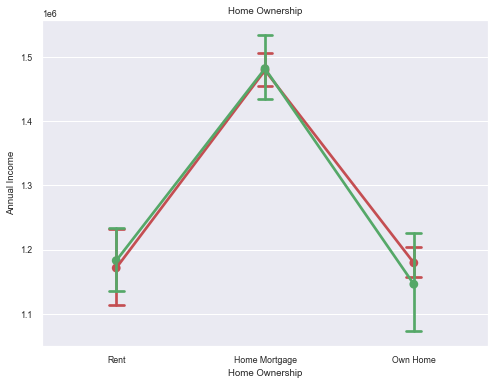

In [61]:
num_feature = 'Annual Income'
col = "Home Ownership"
plt.figure(figsize=(8, 6))
sns.pointplot(x=col, y=num_feature, data=train, capsize=.1, label='train', color='r')
sns.pointplot(x=col, y=num_feature, data=test, capsize=.1, label='test', color='g')
plt.title(col)
plt.show()

In [62]:
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

**Purpose**

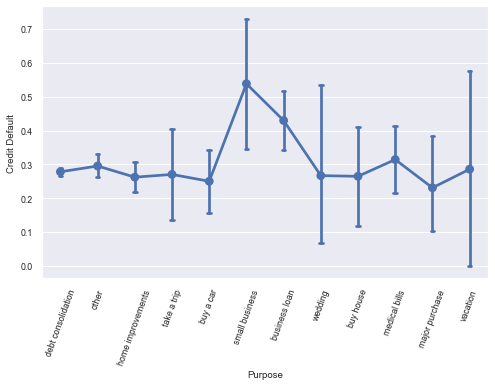

In [63]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Purpose', y=TARGET_NAME, data=df, capsize=.1)
plt.xticks(rotation=70)

plt.show()

In [64]:
def change_purpose(data):
    data.loc[data['Purpose'].isin(['debt consolidation', 'wedding', 'major purchase', 'vacation', 'other', 'home improvements', 'take a trip', 'buy a car', 'buy house', 'medical bills']), 'Purpose'] = 'debt consolidation'
    data.loc[data['Purpose'].isin(['small business', 'business loan']), 'Purpose'] = 'business'
    return data

df = change_purpose(df)
train = change_purpose(train)
test = change_purpose(test)

In [65]:
df['Purpose'].value_counts()

debt consolidation    7311
business               154
Name: Purpose, dtype: int64

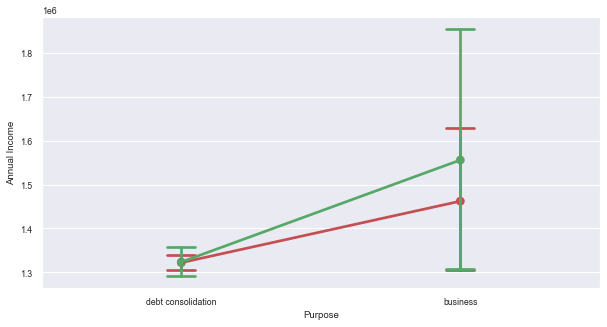

In [66]:
num_feature = 'Annual Income'
col = 'Purpose'
plt.figure(figsize=(10, 5))
sns.pointplot(x=col, y=num_feature, data=train, capsize=.1, label=train, color='r')
sns.pointplot(x=col, y=num_feature, data=test, capsize=.1, label=test, color='g')
plt.show()

## Создание новых признаков

Варианты генерации новых признаков:
1. Категориальные признаки
    - порядковые числа
    - создание бинарных переменных
    - feature encoding
    - target encoding
2. Вещественные признаки
    - Feature discretization
    - Feature binarization
3. Генерация фичей исходя из логики
4. Автоматическая генерация фичей

### Категориальные признаки

### Создание бинарных переменных

**Home Ownership**

Создание бинарных признаков Home Ownership и объединение с основной датой

In [67]:
def home_dummies(data):
    data_home = pd.get_dummies(data["Home Ownership"]).astype(bool)
    data = pd.concat([data, data_home], axis=1)
    return data

In [68]:
df = home_dummies(df)
train = home_dummies(train)
test = home_dummies(test)

**Term**

создание новых бинарных признаков

In [69]:
def term_dummies(data):
    data_term = pd.get_dummies(data["Term"]).astype(bool)
    data = pd.concat([data, data_term], axis=1)
    return data

In [70]:
df = term_dummies(df)
train = term_dummies(train)
test = term_dummies(test)

**Purpose**

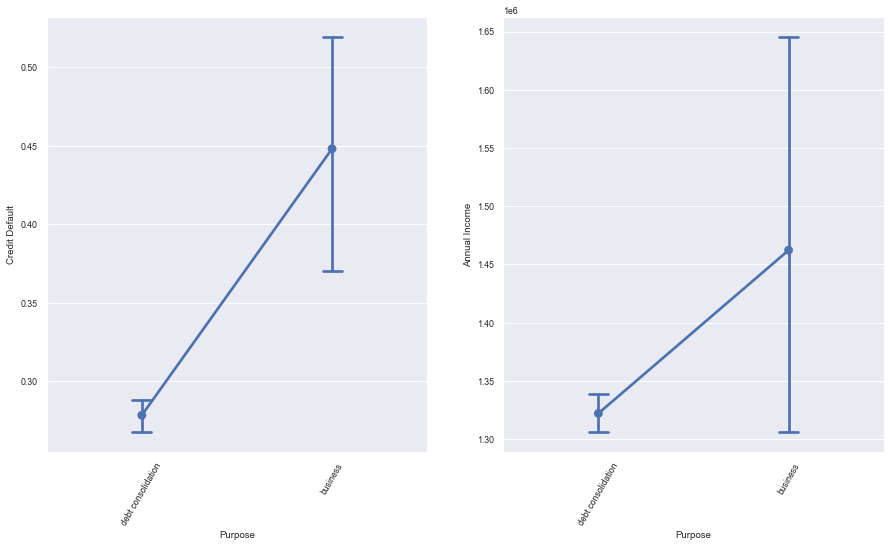

In [71]:
plt.figure(figsize=(15, 8))
plt.subplot(121)
ax1 = sns.pointplot(x='Purpose', y='Credit Default', data=df, capsize=.1)
plt.xticks(rotation=60)
plt.subplot(122)
ax1 = sns.pointplot(x='Purpose', y='Annual Income', data=df, capsize=.1)
plt.xticks(rotation=60)
plt.show()

In [72]:
def purpose_dummies(data):
    data_purpose = pd.get_dummies(data["Purpose"]).astype(bool)
    data = pd.concat([data, data_purpose], axis=1)
    return data

In [73]:
df = purpose_dummies(df)
train = purpose_dummies(train)
test = purpose_dummies(test)

### Feature encoding

Не обнаружено категориальных признаков, коррелирующих между собой.

### Target encoding

**Term**

In [74]:
df_cat = df.groupby('Term', as_index=False).mean()[['Term', 'Credit Default']].rename(
    columns={'Credit Default': 'target_encode_term'})

df_cat

,Term,target_encode_term
0,Long Term,0.420237
1,Short Term,0.233357


In [75]:
df = df.merge(df_cat, on='Term', how='left')
train = train.merge(df_cat, on='Term', how='left')
test = test.merge(df_cat, on='Term', how='left')

**Home Ownership**

In [76]:
df_cat = df.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Credit Default']].rename(
    columns={'Credit Default': 'target_encode_years_in_current_job'})
df_cat

,Home Ownership,target_encode_years_in_current_job
0,Home Mortgage,0.251443
1,Own Home,0.298438
2,Rent,0.313245


In [77]:
df = df.merge(df_cat, on='Home Ownership', how='left')
train = train.merge(df_cat, on='Home Ownership', how='left')
test = test.merge(df_cat, on='Home Ownership', how='left')

### Вещественные признаки

**1) Feature discretization**

не найдено признаков, из которых можно создать категориальные.

**2) Feature binarization**

In [78]:
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Id,target_encode_term,target_encode_years_in_current_job
count,7.465000e+03,7465.000000,7465.000000,7465.000000,7465.000000,7.465000e+03,7465.000000,7465.000000,7465.000000,7465.000000,7.465000e+03,7465.000000,7465.000000,7465.000000,7465.000000,7465.000000,7465.000000
mean,1.324983e+06,6.089216,0.024246,11.131011,18.308413,6.875756e+05,0.161688,33.221567,0.116544,309352.734762,2.904344e+05,18326.073543,722.368922,0.281849,3750.684260,0.281849,0.281849
std,7.560990e+05,3.639256,0.207254,4.905100,7.032671,1.267071e+06,0.450652,14.675535,0.346203,171360.953114,3.182361e+05,11918.106849,25.253288,0.449930,2165.006528,0.081924,0.029918
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.233357,0.251443
25%,9.312850e+05,3.000000,0.000000,8.000000,13.500000,2.796420e+05,0.000000,32.000000,0.000000,180246.000000,1.147410e+05,10106.000000,715.000000,0.000000,1877.000000,0.233357,0.251443
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.795340e+05,0.000000,32.000000,0.000000,309573.000000,2.098930e+05,16087.000000,731.000000,0.000000,3750.000000,0.233357,0.298438
75%,1.499936e+06,10.000000,0.000000,14.000000,21.800000,7.938040e+05,0.000000,32.000000,0.000000,397320.000000,3.616270e+05,23812.000000,738.000000,1.000000,5627.000000,0.420237,0.313245
max,1.014934e+07,10.000000,4.000000,43.000000,57.700000,5.756256e+07,4.000000,118.000000,4.000000,789030.000000,6.506797e+06,136679.000000,751.000000,1.000000,7499.000000,0.420237,0.313245


**Annual Income**

<AxesSubplot:xlabel='Credit Default', ylabel='Annual Income'>

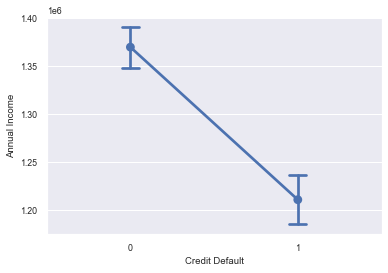

In [79]:
sns.pointplot(data=df, x='Credit Default', y='Annual Income', capsize=.1)

In [80]:
def small_annual_income(data):
    data['small_annual_income'] = (data['Annual Income'] < 1.3 * 10**6).astype('bool')
    return data

In [81]:
df = small_annual_income(df)
train = small_annual_income(train)
test = small_annual_income(test)

**Maximum Open Credit**

<AxesSubplot:xlabel='Credit Default', ylabel='Maximum Open Credit'>

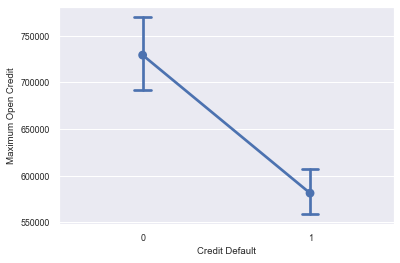

In [82]:
sns.pointplot(data=df, x='Credit Default', y='Maximum Open Credit', capsize=.1)

In [83]:
def small_maximum_open_credit(data):
    data['small_maximum_open_credit'] = (data['Maximum Open Credit'] < 680000).astype('bool')
    return data

In [84]:
df = small_maximum_open_credit(df)
train = small_maximum_open_credit(train)
test = small_maximum_open_credit(test)

In [85]:
train.columns.to_list()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Annual Income NaN',
 'Years in current job NaN',
 'Months since last delinquent NaN',
 'Credit Score NaN',
 'Maximum Open Credit outlier',
 'Current Loan Amount outlier',
 'Credit Score outlier',
 'Home Mortgage',
 'Own Home',
 'Rent',
 'Long Term',
 'Short Term',
 'business',
 'debt consolidation',
 'target_encode_term',
 'target_encode_years_in_current_job',
 'small_annual_income',
 'small_maximum_open_credit']

In [86]:
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [323]:
features = [
    'Annual Income',
    'Annual Income NaN',
#     'Years in current job',
#     'Years in current job NaN',
#     'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
#     'Maximum Open Credit outlier',
    'Number of Credit Problems',
    'Months since last delinquent',
#     'Months since last delinquent NaN',
#     'Bankruptcies',
    'Current Loan Amount',
#     'Current Loan Amount outlier',
    'Current Credit Balance',
#     'Monthly Debt',
    'Credit Score',
     'Credit Score NaN',
#      'Credit Score outlier',
    'Home Mortgage',
    'Own Home',
#     'Rent',
    'Long Term',
#     'Short Term',
    'business',
#     'debt consolidation',
    'target_encode_term',
#     'target_encode_years_in_current_job',
#     'small_annual_income',
#     'small_maximum_open_credit',
]

In [324]:
train_train, train_test = train_test_split(train,
                                           test_size=0.15,
                                           shuffle=True,
                                           stratify=train['Credit Default'],
                                           random_state=1
                                           )

In [325]:
train_train.shape, train_test.shape

((6345, 35), (1120, 35))

In [326]:
X_train = train_train[features + ['Purpose']]
y_train = train_train[TARGET_NAME]

X_test = train_test[features + ['Purpose']]
y_test = train_test[TARGET_NAME]

In [327]:
catb_model = catb.CatBoostClassifier(silent=True, random_state=2,
                                    cat_features=['Purpose']
                                    )

catb_model.fit(X_train, y_train)

pred_train = catb_model.predict(X_train)
pred_test = catb_model.predict(X_test)

print('TRAIN\n', round(metrics.f1_score(y_train, pred_train), 3))
print('TEST\n', round(metrics.f1_score(y_test, pred_test), 3))

TRAIN
 0.618
TEST
 0.32


TRAIN
 0.668
TEST
 0.506

**Во сколько раз меньший класс меньше большего**

In [328]:
weight_min = df[TARGET_NAME].value_counts()[0]/df[TARGET_NAME].value_counts()[1] - 1
weight_min

1.548003802281369

**Масштабирование данных**

In [331]:
NUM_FEATURES = [
    'Annual Income',
#     'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Months since last delinquent',
    'Current Loan Amount',
    'Current Credit Balance',
    'Credit Score']

In [332]:
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train[NUM_FEATURES] = scaler.fit_transform(X_train_norm[NUM_FEATURES])
X_test[NUM_FEATURES] = scaler.transform(X_test_norm[NUM_FEATURES])

**Сравнение моделей**

In [333]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + metrics.classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + metrics.classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [334]:
def evaluate_pred(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [335]:
model_tree = DecisionTreeClassifier(random_state=21,
                                   class_weight={0:1, 1:weight_min},
                                   max_depth=3
                                   )
model_tree.fit(X_train[features], y_train)

evaluate_pred(model_tree, X_train[features], X_test[features], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.92      0.83      4557
           1       0.53      0.23      0.32      1788

    accuracy                           0.72      6345
   macro avg       0.64      0.58      0.58      6345
weighted avg       0.69      0.72      0.69      6345

TEST

              precision    recall  f1-score   support

           0       0.74      0.90      0.82       804
           1       0.45      0.20      0.28       316

    accuracy                           0.71      1120
   macro avg       0.60      0.55      0.55      1120
weighted avg       0.66      0.71      0.66      1120

CONFUSION MATRIX

col_0             0   1
Credit Default         
0               727  77
1               252  64


In [336]:
xgb = XGBClassifier(random_state=21,
                          scale_pos_weight=weight_min,
                          n_estimators=20)
xgb.fit(X_train[features], y_train, eval_metric='auc')

evaluate_pred(xgb, X_train[features], X_test[features], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4557
           1       0.75      0.61      0.67      1788

    accuracy                           0.83      6345
   macro avg       0.80      0.76      0.78      6345
weighted avg       0.83      0.83      0.83      6345

TEST

              precision    recall  f1-score   support

           0       0.78      0.86      0.81       804
           1       0.51      0.38      0.43       316

    accuracy                           0.72      1120
   macro avg       0.64      0.62      0.62      1120
weighted avg       0.70      0.72      0.71      1120

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               688  116
1               197  119


In [337]:
lgbm_model = lgbm.LGBMClassifier(random_state=21,
                                 class_weight={0:1, 1:weight_min},
                                 n_estimators=25
                                )
lgbm_model.fit(X_train[features], y_train)

evaluate_pred(lgbm_model, X_train[features], X_test[features], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.90      0.86      4557
           1       0.66      0.48      0.55      1788

    accuracy                           0.78      6345
   macro avg       0.74      0.69      0.70      6345
weighted avg       0.77      0.78      0.77      6345

TEST

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       804
           1       0.49      0.34      0.40       316

    accuracy                           0.72      1120
   macro avg       0.63      0.60      0.61      1120
weighted avg       0.69      0.72      0.70      1120

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               693  111
1               208  108


In [338]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, weight_min],
                                     eval_metric='F1',
                                     early_stopping_rounds=100,
                                     custom_metric=['Precision', 'Recall'],
                                     use_best_model=True,
                                    cat_features=['Purpose']
                                    )

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_pred(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      4557
           1       0.71      0.57      0.63      1788

    accuracy                           0.81      6345
   macro avg       0.78      0.74      0.76      6345
weighted avg       0.81      0.81      0.81      6345

TEST

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       804
           1       0.53      0.36      0.43       316

    accuracy                           0.73      1120
   macro avg       0.65      0.62      0.63      1120
weighted avg       0.71      0.73      0.71      1120

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               700  104
1               201  115


### Выбор наилучшей модели и подбор гиперпараметров

In [339]:
frozen_params = {'silent':True,
                 'random_state':21,
                 'class_weights':[1, weight_min],
                 'eval_metric':'F1',
                 'early_stopping_rounds':30,
                 'cat_features':['Purpose'],
#                  'use_best_model':True
                }

model_catb = catb.CatBoostClassifier(**frozen_params)

**Подбор гиперпараметров**

In [340]:
params = {'iterations': [50, 100, 200, 300, 350, 400, 450, 500, 600, 700, 1000,  1500, 2000],
         'max_depth': [2, 3, 4, 5]}

In [341]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [342]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4475032317
bestIteration = 0

0:	loss: 0.4475032	best: 0.4475032 (0)	total: 140ms	remaining: 7.16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4475032317
bestIteration = 0

1:	loss: 0.4475032	best: 0.4475032 (0)	total: 242ms	remaining: 6.05s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4475032317
bestIteration = 0

2:	loss: 0.4475032	best: 0.4475032 (0)	total: 331ms	remaining: 5.41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4475032317
bestIteration = 0

3:	loss: 0.4475032	best: 0.4475032 (0)	total: 409ms	remaining: 4.91s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4475032317
bestIteration = 0

4:	loss: 0.4475032	best: 0.4475032 (0)	total: 497ms	remaining: 4.67s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4475032317
bestIteration = 0

5:	loss: 0.4475032	best: 0.4475032 (0)	total: 579ms	remaining: 4.44

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4475032317
bestIteration = 0

50:	loss: 0.4475032	best: 0.4475032 (0)	total: 5.86s	remaining: 115ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4475032317
bestIteration = 0

51:	loss: 0.4475032	best: 0.4475032 (0)	total: 5.99s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.4539705396
bestIteration = 0

Training on fold [1/3]

bestTest = 0.4309441552
bestIteration = 0

Training on fold [2/3]

bestTest = 0.4423671221
bestIteration = 0



In [343]:
grid_search

{'params': {'depth': 2, 'iterations': 50},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30],
              'test-F1-mean': [0.4424272722948879,
               0.35185671440813565,
               0.3852102531989016,
               0.36200575918767447,
               0.3664272672817422,
               0.3660716861443198,
               0.3791140714938988,
               0.3791202355778232,
               0.378795263466205

In [344]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.442427,0.011513,0.441906,0.003675,0.689534,0.000105,0.689565,0.000089
9,9,0.386739,0.058084,0.391224,0.038880,0.666782,0.000579,0.666221,0.000855
2,2,0.385210,0.057403,0.390384,0.038895,0.683320,0.000386,0.683123,0.000615
10,10,0.381082,0.056702,0.383969,0.036161,0.664486,0.001413,0.663832,0.001212
11,11,0.380214,0.056471,0.385519,0.034381,0.662632,0.001555,0.661988,0.001390


### Обучение и оценка финальной модели

In [345]:
evaluate_pred(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      4557
           1       0.54      0.41      0.46      1788

    accuracy                           0.73      6345
   macro avg       0.66      0.64      0.64      6345
weighted avg       0.72      0.73      0.72      6345

TEST

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       804
           1       0.49      0.36      0.41       316

    accuracy                           0.72      1120
   macro avg       0.63      0.61      0.61      1120
weighted avg       0.69      0.72      0.70      1120

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               688  116
1               203  113


In [346]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, weight_min],
                                     eval_metric='F1',
                                     early_stopping_rounds=100,
                                     use_best_model=True,
                                     max_depth=2,
                                     cat_features=['Purpose'],
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=300
                                    )

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_pred(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      4557
           1       0.57      0.43      0.49      1788

    accuracy                           0.75      6345
   macro avg       0.68      0.65      0.66      6345
weighted avg       0.73      0.75      0.74      6345

TEST

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       804
           1       0.50      0.36      0.42       316

    accuracy                           0.72      1120
   macro avg       0.64      0.61      0.62      1120
weighted avg       0.70      0.72      0.70      1120

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               690  114
1               201  115


## Балансировка по целевому признакому

In [347]:
def balance_df_by_target(df, target_name, method='over'):
    assert method in ['over', 'under', 'tomek', 'smote'], 'incorrect method'
    
    target_counts = df[target_name].value_counts()
    
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
        
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)
    
    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        t1 = TomekLinks()
        X_tomek, y_tomek = t1.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
        
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)
        
    return df.sample(frac=1)

In [348]:
# import inspect
# print(inspect.getsource(balance_df_by_target))

In [349]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_xgb = XGBClassifier(random_state=21, eval_metric='auc')
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
    
    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'lgbm': model_lgbm,
        'xgb': model_xgb,
        'catb': model_catb
    }
    return models

In [350]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [351]:
def run_experiment(X_train, y_train, X_test, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Wrong method'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        report_train = metrics.classification_report(y_train, pred_train, output_dict=True)
        report_test = metrics.classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)
        
        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test,
        }, ignore_index=True)
    return stata, models

**NOT balanced**

In [352]:
%%time
stata_not_balanced, models_not_balanced = run_experiment(X_train[features], y_train, X_test[features], y_test, method='not')
stata_not_balanced

Wall time: 4.53 s


,model_name,f1_macro_train_not,f1_macro_test_not,f1_0_train_not,f1_0_test_not,f1_1_train_not,f1_1_test_not
0,lr,0.534636,0.517397,0.836298,0.833243,0.232975,0.201550
1,knn,0.679221,0.526810,0.857027,0.796359,0.501414,0.257261
2,tree,1.000000,0.557540,1.000000,0.755857,1.000000,0.359223
3,lgbm,0.806200,0.561128,0.913317,0.825627,0.699084,0.296629
4,xgb,0.921475,0.578409,0.959729,0.819318,0.883221,0.337500
5,catb,0.752770,0.567791,0.895069,0.832133,0.610472,0.303448


**OVER sampling**

In [353]:
df_for_balancing = pd.concat([X_train[features], y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
df_balanced[TARGET_NAME].value_counts()

0    4557
1    3576
Name: Credit Default, dtype: int64

In [354]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [355]:
%%time
stata_balanced_over, models_balanced_over = run_experiment(X_train_balanced, y_train_balanced, X_test[features], y_test, method='over')
stata_balanced_over

Wall time: 5.96 s


,model_name,f1_macro_train_over,f1_macro_test_over,f1_0_train_over,f1_0_test_over,f1_1_train_over,f1_1_test_over
0,lr,0.616515,0.609456,0.712375,0.787990,0.520656,0.430921
1,knn,0.749551,0.578124,0.792140,0.754408,0.706963,0.401840
2,tree,1.000000,0.556108,1.000000,0.750311,1.000000,0.361905
3,lgbm,0.875559,0.606139,0.892191,0.779156,0.858927,0.433121
4,xgb,0.965703,0.585862,0.969777,0.777031,0.961630,0.394693
5,catb,0.860688,0.618611,0.880112,0.789895,0.841263,0.447326


**UNDER sampling**

In [356]:
df_for_balancing = pd.concat([X_train[features], y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
df_balanced[TARGET_NAME].value_counts()

1    1788
0    1788
Name: Credit Default, dtype: int64

In [357]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [358]:
%%time
stata_balanced_under, models_balanced_under = run_experiment(X_train_balanced, y_train_balanced, X_test[features], y_test, method='under')
stata_balanced_under

Wall time: 3.26 s


,model_name,f1_macro_train_under,f1_macro_test_under,f1_0_train_under,f1_0_test_under,f1_1_train_under,f1_1_test_under
0,lr,0.629036,0.595543,0.636712,0.718686,0.621359,0.472401
1,knn,0.734610,0.565681,0.743368,0.681241,0.725853,0.450122
2,tree,1.000000,0.536896,1.000000,0.641921,1.000000,0.431871
3,lgbm,0.932326,0.586667,0.932061,0.690000,0.932591,0.483333
4,xgb,0.986297,0.563410,0.986248,0.653846,0.986347,0.472973
5,catb,0.877748,0.595255,0.875321,0.687045,0.880175,0.503464


**TOMEK sampling**

In [359]:
df_for_balancing = pd.concat([X_train[features], y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='tomek')
df_balanced[TARGET_NAME].value_counts()

0    4023
1    1788
Name: Credit Default, dtype: int64

In [360]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [361]:
%%time
stata_balanced_tomek, models_balanced_tomek = run_experiment(X_train_balanced, y_train_balanced, X_test[features], y_test, method='tomek')
stata_balanced_tomek

Wall time: 4.49 s


,model_name,f1_macro_train_tomek,f1_macro_test_tomek,f1_0_train_tomek,f1_0_test_tomek,f1_1_train_tomek,f1_1_test_tomek
0,lr,0.581976,0.549270,0.821741,0.820513,0.342211,0.278027
1,knn,0.722564,0.549349,0.856579,0.778698,0.588549,0.320000
2,tree,1.000000,0.548509,1.000000,0.737571,1.000000,0.359447
3,lgbm,0.833056,0.597827,0.913296,0.815072,0.752816,0.380583
4,xgb,0.936847,0.593433,0.963625,0.800710,0.910069,0.386157
5,catb,0.790488,0.597195,0.895262,0.820896,0.685714,0.373494


**SMOTE sampling**

In [362]:
df_for_balancing = pd.concat([X_train[features], y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
df_balanced[TARGET_NAME].value_counts()

1    4557
0    4557
Name: Credit Default, dtype: int64

In [363]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [364]:
%%time
stata_balanced_smote, models_balanced_smote = run_experiment(X_train_balanced, y_train_balanced, X_test[features], y_test, method='smote')
stata_balanced_smote

Wall time: 6.12 s


,model_name,f1_macro_train_smote,f1_macro_test_smote,f1_0_train_smote,f1_0_test_smote,f1_1_train_smote,f1_1_test_smote
0,lr,0.628943,0.599329,0.646776,0.736702,0.611111,0.461957
1,knn,0.826043,0.558845,0.807796,0.686071,0.844290,0.431619
2,tree,1.000000,0.558785,1.000000,0.723847,1.000000,0.393723
3,lgbm,0.893349,0.599243,0.896801,0.802842,0.889897,0.395644
4,xgb,0.955326,0.595711,0.956213,0.807963,0.954439,0.383459
5,catb,0.887661,0.597386,0.892444,0.805882,0.882879,0.388889


In [365]:
stata_combined = stata_not_balanced.merge(stata_balanced_over, on='model_name') \
                                    .merge(stata_balanced_under, on='model_name') \
                                    .merge(stata_balanced_tomek, on='model_name') \
                                    .merge(stata_balanced_smote, on='model_name')

In [366]:
stata_combined.describe()[
    [f'f1_macro_test_not', f'f1_macro_test_over',
     f'f1_macro_test_under', f'f1_macro_test_tomek', f'f1_macro_test_smote',
     f'f1_1_test_not', f'f1_1_test_over',
     f'f1_1_test_under', f'f1_1_test_tomek', f'f1_1_test_smote']
]

,f1_macro_test_not,f1_macro_test_over,f1_macro_test_under,f1_macro_test_tomek,f1_macro_test_smote,f1_1_test_not,f1_1_test_over,f1_1_test_under,f1_1_test_tomek,f1_1_test_smote
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.551513,0.592383,0.573909,0.572597,0.584883,0.292602,0.411634,0.469027,0.349618,0.409215
std,0.024047,0.023368,0.022954,0.025848,0.020236,0.056793,0.031507,0.025122,0.042339,0.030933
min,0.517397,0.556108,0.536896,0.548509,0.558785,0.201550,0.361905,0.431871,0.278027,0.383459
25%,0.534493,0.580059,0.563978,0.549290,0.568061,0.267103,0.396480,0.455691,0.329862,0.390097
50%,0.559334,0.596000,0.576174,0.571391,0.596548,0.300039,0.416381,0.472687,0.366470,0.394684
75%,0.566125,0.608626,0.593108,0.596254,0.598779,0.328987,0.432571,0.480743,0.378810,0.422625
max,0.578409,0.618611,0.595543,0.597827,0.599329,0.359223,0.447326,0.503464,0.386157,0.461957


In [367]:
stata_combined.sort_values('f1_1_test_over', ascending=False).iloc[0]

model_name                  catb
f1_macro_train_not       0.75277
f1_macro_test_not       0.567791
f1_0_train_not          0.895069
f1_0_test_not           0.832133
f1_1_train_not          0.610472
f1_1_test_not           0.303448
f1_macro_train_over     0.860688
f1_macro_test_over      0.618611
f1_0_train_over         0.880112
f1_0_test_over          0.789895
f1_1_train_over         0.841263
f1_1_test_over          0.447326
f1_macro_train_under    0.877748
f1_macro_test_under     0.595255
f1_0_train_under        0.875321
f1_0_test_under         0.687045
f1_1_train_under        0.880175
f1_1_test_under         0.503464
f1_macro_train_tomek    0.790488
f1_macro_test_tomek     0.597195
f1_0_train_tomek        0.895262
f1_0_test_tomek         0.820896
f1_1_train_tomek        0.685714
f1_1_test_tomek         0.373494
f1_macro_train_smote    0.887661
f1_macro_test_smote     0.597386
f1_0_train_smote        0.892444
f1_0_test_smote         0.805882
f1_1_train_smote        0.882879
f1_1_test_

лучшая комбинация балансировки-модели: CatboostClassifier and OverSampling

In [368]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
df_balanced[TARGET_NAME].value_counts()

0    4557
1    3576
Name: Credit Default, dtype: int64

In [369]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

## Подбор модели с лучшей балансировкой

In [416]:
frozen_params = {'silent':True,
                 'random_state':21,
#                  'class_weights':[1, weight_min],
                 'eval_metric':'F1',
                 'early_stopping_rounds':30,
                 'cat_features':['Purpose'],
#                  'use_best_model':True
                }

model_catb = catb.CatBoostClassifier(**frozen_params)

**Подбор гиперпараметров**

In [417]:
params = {'iterations': [50, 100, 200, 300, 350, 400, 450, 500, 600, 700, 1000,  1500, 2000],
         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
         'reg_lambda': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000],
         'learning_rate': [10, 1, 0.1, 0.01, 0.001]}

In [418]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
grid_search = model_catb.grid_search(params, X_train_balanced, y_train_balanced, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

0:	loss: 0.4758403	best: 0.4758403 (0)	total: 192ms	remaining: 13m 18s

bestTest = 0.5836909871
bestIteration = 27

1:	loss: 0.5836910	best: 0.5836910 (1)	total: 327ms	remaining: 11m 20s

bestTest = 0.4918300654
bestIteration = 49

2:	loss: 0.4918301	best: 0.5836910 (1)	total: 481ms	remaining: 11m 6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

3:	loss: 0.4654731	best: 0.5836910 (1)	total: 569ms	remaining: 9m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

4:	loss: 0.4654731	best: 0.5836910 (1)	total: 657ms	remaining: 9m 6s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

5:	loss: 0.4758403	best: 0.5836910 (1)	total: 762ms	remaining: 8m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5976863753
bestIteration = 4

6:	loss: 0.5976864	best: 0.5976864 (6)	total: 859ms	remaining: 8m 29s

bestTest = 0.4971932638
bestIteration = 48

7:	loss: 0.4971933	best: 0.5976864 (6)	total: 1.05s	remaining: 9m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

8:	loss: 0.4654731	best: 0.5976864 (6)	total: 1.19s	remaining: 9m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

9:	loss: 0.4664970	best: 0.5976864 (6)	total: 1.3s	remaining: 9m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

10:	loss: 0.4741834	best: 0.5976864 (6)	total: 1.42s	remaining: 8m 56s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

11:	loss: 0.5835616	best: 0.5976864 (6)	total: 1.54s	remaining: 8m 54s

bestTest = 0.4825291181
bestIteration = 34

12:	loss: 0.4825291	best: 0.5976864 (6)	total: 1.72s	remaining: 9m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

13:	loss: 0.4646809	best: 0.5976864 (6)	total: 1.82s	remaining: 8m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

14:	loss: 0.4646809	best: 0.5976864 (6)	total: 1.9s	remaining: 8m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

15:	loss: 0.4741834	best: 0.5976864 (6)	total: 1.99s	remaining: 8m 34s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5911047346
bestIteration = 30

16:	loss: 0.5911047	best: 0.5976864 (6)	total: 2.13s	remaining: 8m 39s

bestTest = 0.4909390445
bestIteration = 47

17:	loss: 0.4909390	best: 0.5976864 (6)	total: 2.28s	remaining: 8m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

18:	loss: 0.4646809	best: 0.5976864 (6)	total: 2.37s	remaining: 8m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

19:	loss: 0.4646809	best: 0.5976864 (6)	total: 2.44s	remaining: 8m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

20:	loss: 0.6245999	best: 0.6245999 (20)	total: 2.53s	remaining: 8m 18s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5945595855
bestIteration = 4

21:	loss: 0.5945596	best: 0.6245999 (20)	total: 2.61s	remaining: 8m 11s

bestTest = 0.499594485
bestIteration = 38

22:	loss: 0.4995945	best: 0.6245999 (20)	total: 2.73s	remaining: 8m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

23:	loss: 0.4664970	best: 0.6245999 (20)	total: 2.8s	remaining: 8m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

24:	loss: 0.4664970	best: 0.6245999 (20)	total: 2.88s	remaining: 7m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

25:	loss: 0.4808081	best: 0.6245999 (20)	total: 2.97s	remaining: 7m 52s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6106032907
bestIteration = 3

26:	loss: 0.6106033	best: 0.6245999 (20)	total: 3.06s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

27:	loss: 0.4646809	best: 0.6245999 (20)	total: 3.13s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

28:	loss: 0.4646809	best: 0.6245999 (20)	total: 3.2s	remaining: 7m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

29:	loss: 0.4646809	best: 0.6245999 (20)	total: 3.27s	remaining: 7m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4725158562
bestIteration = 1

30:	loss: 0.4725159	best: 0.6245999 (20)	total: 3.36s	remaining: 7m 27s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5821727019
bestIteration = 37

31:	loss: 0.5821727	best: 0.6245999 (20)	total: 3.5s	remaining: 7m 31s

bestTest = 0.4796084829
bestIteration = 44

32:	loss: 0.4796085	best: 0.6245999 (20)	total: 3.62s	remaining: 7m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

33:	loss: 0.4646809	best: 0.6245999 (20)	total: 3.7s	remaining: 7m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

34:	loss: 0.4646809	best: 0.6245999 (20)	total: 3.77s	remaining: 7m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6224588577
bestIteration = 8

35:	loss: 0.6224589	best: 0.6245999 (20)	total: 3.88s	remaining: 7m 24s


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5695557174
bestIteration = 41

36:	loss: 0.5695557	best: 0.6245999 (20)	total: 4.02s	remaining: 7m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

37:	loss: 0.4646809	best: 0.6245999 (20)	total: 4.1s	remaining: 7m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

38:	loss: 0.4664970	best: 0.6245999 (20)	total: 4.18s	remaining: 7m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

39:	loss: 0.4664970	best: 0.6245999 (20)	total: 4.27s	remaining: 7m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

40:	loss: 0.4758403	best: 0.6245999 (20)	total: 4.34s	remaining: 7m 16s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5836909871
bestIteration = 27

41:	loss: 0.5836910	best: 0.6245999 (20)	total: 4.5s	remaining: 7m 20s

bestTest = 0.5344563553
bestIteration = 86

42:	loss: 0.5344564	best: 0.6245999 (20)	total: 4.74s	remaining: 7m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

43:	loss: 0.4654731	best: 0.6245999 (20)	total: 4.82s	remaining: 7m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

44:	loss: 0.4654731	best: 0.6245999 (20)	total: 4.9s	remaining: 7m 27s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

45:	loss: 0.4758403	best: 0.6245999 (20)	total: 5s	remaining: 7m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5976863753
bestIteration = 4

46:	loss: 0.5976864	best: 0.6245999 (20)	total: 5.11s	remaining: 7m 27s

bestTest = 0.5258288358
bestIteration = 91

47:	loss: 0.5258288	best: 0.6245999 (20)	total: 5.44s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

48:	loss: 0.4654731	best: 0.6245999 (20)	total: 5.54s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

49:	loss: 0.4664970	best: 0.6245999 (20)	total: 5.63s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

50:	loss: 0.4741834	best: 0.6245999 (20)	total: 5.71s	remaining: 7m 39s
Stopped by overfitting detector  (30

learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5312977099
bestIteration = 94

52:	loss: 0.5312977	best: 0.6245999 (20)	total: 6.09s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

53:	loss: 0.4646809	best: 0.6245999 (20)	total: 6.16s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

54:	loss: 0.4646809	best: 0.6245999 (20)	total: 6.22s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4741833509
bestIteration = 1

55:	loss: 0.4741834	best: 0.6245999 (20)	total: 6.3s	remaining: 7m 41s

bestTest = 0.593064402
bestIteration = 81

56:	loss: 0.5930644	best: 0.6245999 (20)	total: 6.59s	remaining: 7m 54s

bestTest = 0.5186915888
bestIteration = 99

57:	loss: 0.5186916	best: 0.6245999 (20)	total: 6.85s	remaining: 8m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

58:	loss: 0.4646809	best: 0.6245999 (20)	total: 6.92s	remaining: 8m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

59:	loss: 0.4646809	best: 0.6245999 (20)	total: 6.99s	remaining: 7m 57s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.6245999086
bestIteration = 3

60:	loss: 0.6245999	best: 0.6245999 (20)	total: 7.07s	remaining: 7m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5945595855
bestIteration = 4

61:	loss: 0.5945596	best: 0.6245999 (20)	total: 7.16s	remaining: 7m 53s

bestTest = 0.5259938838
bestIteration = 98

62:	loss: 0.5259939	best: 0.6245999 (20)	total: 7.41s	remaining: 8m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

63:	loss: 0.4664970	best: 0.6245999 (20)	total: 7.48s	remaining: 7m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

64:	loss: 0.4664970	best: 0.6245999 (20)	total: 7.55s	remaining: 7m 55s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

65:	loss: 0.4808081	best: 0.6245999 (20)	total: 7.64s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6106032907
bestIteration = 3

66:	loss: 0.6106033	best: 0.6245999 (20)	total: 7.73s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

67:	loss: 0.4646809	best: 0.6245999 (20)	total: 7.81s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

68:	loss: 0.4646809	best: 0.6245999 (20)	total: 7.88s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

69:	loss: 0.4646809	best: 0.6245999 (20)	total: 7.95s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4725158562
bestIteration = 1

70:	loss: 0.4725159	best: 0.6245999 (20)	total: 8.03

learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

71:	loss: 0.5821727	best: 0.6245999 (20)	total: 8.21s	remaining: 7m 46s

bestTest = 0.5150346955
bestIteration = 96

72:	loss: 0.5150347	best: 0.6245999 (20)	total: 8.46s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

73:	loss: 0.4646809	best: 0.6245999 (20)	total: 8.54s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

74:	loss: 0.4646809	best: 0.6245999 (20)	total: 8.61s	remaining: 7m 48s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6224588577
bestIteration = 8

75:	loss: 0.6224589	best: 0.6245999 (20)	total: 8.73s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

76:	loss: 0.5814788	best: 0.6245999 (20)	total: 8.99s	remaining: 7m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

77:	loss: 0.4646809	best: 0.6245999 (20)	total: 9.06s	remaining: 7m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

78:	loss: 0.4664970	best: 0.6245999 (20)	total: 9.15s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

79:	loss: 0.4664970	best: 0.6245999 (20)	total: 9.22s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

80:	loss: 0.4758403	best: 0.6245999 (20)	total: 9.2

learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5649963689
bestIteration = 197

82:	loss: 0.5649964	best: 0.6245999 (20)	total: 9.74s	remaining: 7m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

83:	loss: 0.4654731	best: 0.6245999 (20)	total: 9.81s	remaining: 7m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

84:	loss: 0.4654731	best: 0.6245999 (20)	total: 9.86s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

85:	loss: 0.4758403	best: 0.6245999 (20)	total: 9.91s	remaining: 7m 49s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5976863753
bestIteration = 4

86:	loss: 0.5976864	best: 0.6245999 (20)	total: 9.96s	remaining: 7m 46s

bestTest = 0.5545851528
bestIteration = 175

87:	loss: 0.5545852	best: 0.6245999 (20)	total: 10.3s	remaining: 7m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

88:	loss: 0.4654731	best: 0.6245999 (20)	total: 10.3s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

89:	loss: 0.4664970	best: 0.6245999 (20)	total: 10.4s	remaining: 7m 50s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

90:	loss: 0.4741834	best: 0.6245999 (20)	total: 10.5s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

91:	loss: 0.5835616	best: 0.6245999 (20)	total: 10.5s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

92:	loss: 0.5346535	best: 0.6245999 (20)	total: 10.7s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

93:	loss: 0.4646809	best: 0.6245999 (20)	total: 10.8s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

94:	loss: 0.4646809	best: 0.6245999 (20)	total: 10.8s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

95:	loss: 0.4741834	best: 0.6245999 (20)	total: 10

learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

96:	loss: 0.6137640	best: 0.6245999 (20)	total: 11.2s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

97:	loss: 0.5445104	best: 0.6245999 (20)	total: 11.5s	remaining: 7m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

98:	loss: 0.4646809	best: 0.6245999 (20)	total: 11.6s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

99:	loss: 0.4646809	best: 0.6245999 (20)	total: 11.6s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

100:	loss: 0.6245999	best: 0.6245999 (20)	total: 11.7s	remaining: 7m 48s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5945595855
bestIteration = 4

101:	loss: 0.5945596	best: 0.6245999 (20)	total: 11.7s	remaining: 7m 46s

bestTest = 0.5549048316
bestIteration = 198

102:	loss: 0.5549048	best: 0.6245999 (20)	total: 12.1s	remaining: 7m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

103:	loss: 0.4664970	best: 0.6245999 (20)	total: 12.2s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

104:	loss: 0.4664970	best: 0.6245999 (20)	total: 12.2s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

105:	loss: 0.4808081	best: 0.6245999 (20)	total: 12.3s	remaining: 7m 49s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6106032907
bestIteration = 3

106:	loss: 0.6106033	best: 0.6245999 (20)	total: 12.3s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

107:	loss: 0.4646809	best: 0.6245999 (20)	total: 12.4s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

108:	loss: 0.4646809	best: 0.6245999 (20)	total: 12.4s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

109:	loss: 0.4646809	best: 0.6245999 (20)	total: 12.5s	remaining: 7m 39s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4725158562
bestIteration = 1

110:	loss: 0.4725159	best: 0.6245999 (20)	total: 12.5s	remaining: 7m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

111:	loss: 0.5821727	best: 0.6245999 (20)	total: 12.7s	remaining: 7m 37s

bestTest = 0.5682980278
bestIteration = 198

112:	loss: 0.5682980	best: 0.6245999 (20)	total: 13.1s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

113:	loss: 0.4646809	best: 0.6245999 (20)	total: 13.1s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

114:	loss: 0.4646809	best: 0.6245999 (20)	total: 13.2s	remaining: 7m 43s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.6224588577
bestIteration = 8

115:	loss: 0.6224589	best: 0.6245999 (20)	total: 13.3s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

116:	loss: 0.5814788	best: 0.6245999 (20)	total: 13.4s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

117:	loss: 0.4646809	best: 0.6245999 (20)	total: 13.5s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

118:	loss: 0.4664970	best: 0.6245999 (20)	total: 13.6s	remaining: 7m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

119:	loss: 0.4664970	best: 0.6245999 (20)	total: 13.6s	remaining: 7m 38s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

120:	loss: 0.4758403	best: 0.6245999 (20)	total: 13.7s	remaining: 7m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5836909871
bestIteration = 27

121:	loss: 0.5836910	best: 0.6245999 (20)	total: 13.8s	remaining: 7m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.568115942
bestIteration = 200

122:	loss: 0.5681159	best: 0.6245999 (20)	total: 14.2s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

123:	loss: 0.4654731	best: 0.6245999 (20)	total: 14.2s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

124:	loss: 0.4654731	best: 0.6245999 (20)	total: 14.3s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361


learning rate is greater than 1. You probably need to decrease learning rate.


bestIteration = 1

125:	loss: 0.4758403	best: 0.6245999 (20)	total: 14.3s	remaining: 7m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5976863753
bestIteration = 4

126:	loss: 0.5976864	best: 0.6245999 (20)	total: 14.4s	remaining: 7m 37s

bestTest = 0.5689530686
bestIteration = 287

127:	loss: 0.5689531	best: 0.6245999 (20)	total: 14.9s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

128:	loss: 0.4654731	best: 0.6245999 (20)	total: 15s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

129:	loss: 0.4664970	best: 0.6245999 (20)	total: 15s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

130:	loss: 0.4741834	best: 0.6245999 (20)	total: 15.1s	remaining: 7m 44s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

131:	loss: 0.5835616	best: 0.6245999 (20)	total: 15.2s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

132:	loss: 0.5346535	best: 0.6245999 (20)	total: 15.4s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

133:	loss: 0.4646809	best: 0.6245999 (20)	total: 15.4s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

134:	loss: 0.4646809	best: 0.6245999 (20)	total: 15.5s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

135:	loss: 0.4741834	best: 0.6245999 (20)	total: 15.6s	remaining: 7m 40s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

136:	loss: 0.6137640	best: 0.6245999 (20)	total: 15.9s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

137:	loss: 0.5445104	best: 0.6245999 (20)	total: 16.3s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

138:	loss: 0.4646809	best: 0.6245999 (20)	total: 16.3s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

139:	loss: 0.4646809	best: 0.6245999 (20)	total: 16.4s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

140:	loss: 0.6245999	best: 0.6245999 (20)	total: 16.4s	remaining: 7m 48s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5945595855
bestIteration = 4

141:	loss: 0.5945596	best: 0.6245999 (20)	total: 16.5s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5604075691
bestIteration = 213

142:	loss: 0.5604076	best: 0.6245999 (20)	total: 16.9s	remaining: 7m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

143:	loss: 0.4664970	best: 0.6245999 (20)	total: 17s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

144:	loss: 0.4664970	best: 0.6245999 (20)	total: 17s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4808080808
bestIteration = 4

145:	loss: 0.4808081	best: 0.6245999 (20)	total: 17.1s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6106032907
bestIteration = 3

146:	loss: 0.6106033	best: 0.6245999 (20)	total: 17.2s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

147:	loss: 0.4646809	best: 0.6245999 (20)	total: 17.2s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

148:	loss: 0.4646809	best: 0.6245999 (20)	total: 17.3s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

149:	loss: 0.4646809	best: 0.6245999 (20)	total: 17.3s	remaining: 7m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4725158562
bestIteration = 1

150:	loss: 0.4725159	best: 0.6245999 (20)	total: 17.4s	remaining: 7m 41s
Stopped by overfitting detec

learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5821727019
bestIteration = 37

151:	loss: 0.5821727	best: 0.6245999 (20)	total: 17.5s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5682980278
bestIteration = 198

152:	loss: 0.5682980	best: 0.6245999 (20)	total: 18s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

153:	loss: 0.4646809	best: 0.6245999 (20)	total: 18s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

154:	loss: 0.4646809	best: 0.6245999 (20)	total: 18.1s	remaining: 7m 47s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6224588577
bestIteration = 8

155:	loss: 0.6224589	best: 0.6245999 (20)	total: 18.2s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

156:	loss: 0.5814788	best: 0.6245999 (20)	total: 18.4s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

157:	loss: 0.4646809	best: 0.6245999 (20)	total: 18.4s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

158:	loss: 0.4664970	best: 0.6245999 (20)	total: 18.5s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

159:	loss: 0.4664970	best: 0.6245999 (20)	total: 18.5s	remaining: 7m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

160:	loss: 0.4758403	best: 0.6245999 (20)	tota

learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.568115942
bestIteration = 200

162:	loss: 0.5681159	best: 0.6245999 (20)	total: 19.2s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

163:	loss: 0.4654731	best: 0.6245999 (20)	total: 19.3s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

164:	loss: 0.4654731	best: 0.6245999 (20)	total: 19.3s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

165:	loss: 0.4758403	best: 0.6245999 (20)	total: 19.4s	remaining: 7m 45s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5976863753
bestIteration = 4

166:	loss: 0.5976864	best: 0.6245999 (20)	total: 19.4s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5689530686
bestIteration = 287

167:	loss: 0.5689531	best: 0.6245999 (20)	total: 20s	remaining: 7m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

168:	loss: 0.4654731	best: 0.6245999 (20)	total: 20.1s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

169:	loss: 0.4664970	best: 0.6245999 (20)	total: 20.1s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4741833509
bestIteration = 1

170:	loss: 0.4741834	best: 0.6245999 (20)	total: 20.2s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

171:	loss: 0.5835616	best: 0.6245999 (20)	total: 20.3s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

172:	loss: 0.5346535	best: 0.6245999 (20)	total: 20.5s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

173:	loss: 0.4646809	best: 0.6245999 (20)	total: 20.6s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

174:	loss: 0.4646809	best: 0.6245999 (20)	total: 20.6s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4741833509
bestIteration = 1

175:	loss: 0.4741834	best: 0.6245999 (20)	total: 20.7s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

176:	loss: 0.6137640	best: 0.6245999 (20)	total: 21.1s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

177:	loss: 0.5445104	best: 0.6245999 (20)	total: 21.4s	remaining: 7m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

178:	loss: 0.4646809	best: 0.6245999 (20)	total: 21.4s	remaining: 7m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

179:	loss: 0.4646809	best: 0.6245999 (20)	total: 21.5s	remaining: 7m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

180:	loss: 0.6245999	best: 0.6245999 (20)	total: 21.6s	remaining: 7m 53s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5945595855
bestIteration = 4

181:	loss: 0.5945596	best: 0.6245999 (20)	total: 21.6s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5604075691
bestIteration = 213

182:	loss: 0.5604076	best: 0.6245999 (20)	total: 22.1s	remaining: 7m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

183:	loss: 0.4664970	best: 0.6245999 (20)	total: 22.1s	remaining: 7m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

184:	loss: 0.4664970	best: 0.6245999 (20)	total: 22.2s	remaining: 7m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

185:	loss: 0.4808081	best: 0.6245999 (20)	total: 22.2s	remaining: 7m 54s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6106032907
bestIteration = 3

186:	loss: 0.6106033	best: 0.6245999 (20)	total: 22.3s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

187:	loss: 0.4646809	best: 0.6245999 (20)	total: 22.3s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

188:	loss: 0.4646809	best: 0.6245999 (20)	total: 22.4s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

189:	loss: 0.4646809	best: 0.6245999 (20)	total: 22.5s	remaining: 7m 49s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4725158562
bestIteration = 1

190:	loss: 0.4725159	best: 0.6245999 (20)	total: 22.5s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

191:	loss: 0.5821727	best: 0.6245999 (20)	total: 22.7s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5682980278
bestIteration = 198

192:	loss: 0.5682980	best: 0.6245999 (20)	total: 23.2s	remaining: 7m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

193:	loss: 0.4646809	best: 0.6245999 (20)	total: 23.2s	remaining: 7m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

194:	loss: 0.4646809	best: 0.6245999 (20)	total: 23.3s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.6224588577
bestIteration = 8

195:	loss: 0.6224589	best: 0.6245999 (20)	total: 23.3s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

196:	loss: 0.5814788	best: 0.6245999 (20)	total: 23.5s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

197:	loss: 0.4646809	best: 0.6245999 (20)	total: 23.6s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

198:	loss: 0.4664970	best: 0.6245999 (20)	total: 23.6s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

199:	loss: 0.4664970	best: 0.6245999 (20)	total: 23.7s	remaining: 7m 49s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

200:	loss: 0.4758403	best: 0.6245999 (20)	total: 23.8s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5836909871
bestIteration = 27

201:	loss: 0.5836910	best: 0.6245999 (20)	total: 23.9s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.568115942
bestIteration = 200

202:	loss: 0.5681159	best: 0.6245999 (20)	total: 24.2s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

203:	loss: 0.4654731	best: 0.6245999 (20)	total: 24.3s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

204:	loss: 0.4654731	best: 0.6245999 (20)	total: 24.3s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

205:	loss: 0.4758403	best: 0.6245999 (20)	tot

learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5976863753
bestIteration = 4

206:	loss: 0.5976864	best: 0.6245999 (20)	total: 24.5s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5689530686
bestIteration = 287

207:	loss: 0.5689531	best: 0.6245999 (20)	total: 25s	remaining: 7m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

208:	loss: 0.4654731	best: 0.6245999 (20)	total: 25s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

209:	loss: 0.4664970	best: 0.6245999 (20)	total: 25.1s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

210:	loss: 0.4741834	best: 0.6245999 (20)	total: 25.1s	remaining: 7m 50s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

211:	loss: 0.5835616	best: 0.6245999 (20)	total: 25.2s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

212:	loss: 0.5346535	best: 0.6245999 (20)	total: 25.4s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

213:	loss: 0.4646809	best: 0.6245999 (20)	total: 25.5s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

214:	loss: 0.4646809	best: 0.6245999 (20)	total: 25.5s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

215:	loss: 0.4741834	best: 0.6245999 (20)	total: 25.6s	remaining: 7m 47s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

216:	loss: 0.6137640	best: 0.6245999 (20)	total: 25.9s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

217:	loss: 0.5445104	best: 0.6245999 (20)	total: 26.2s	remaining: 7m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

218:	loss: 0.4646809	best: 0.6245999 (20)	total: 26.3s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

219:	loss: 0.4646809	best: 0.6245999 (20)	total: 26.4s	remaining: 7m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

220:	loss: 0.6245999	best: 0.6245999 (20)	total: 26.4s	remaining: 7m 50s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5945595855
bestIteration = 4

221:	loss: 0.5945596	best: 0.6245999 (20)	total: 26.5s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5604075691
bestIteration = 213

222:	loss: 0.5604076	best: 0.6245999 (20)	total: 26.9s	remaining: 7m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

223:	loss: 0.4664970	best: 0.6245999 (20)	total: 26.9s	remaining: 7m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

224:	loss: 0.4664970	best: 0.6245999 (20)	total: 27s	remaining: 7m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

225:	loss: 0.4808081	best: 0.6245999 (20)	total: 27.1s	remaining: 7m 50s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6106032907
bestIteration = 3

226:	loss: 0.6106033	best: 0.6245999 (20)	total: 27.1s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

227:	loss: 0.4646809	best: 0.6245999 (20)	total: 27.2s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

228:	loss: 0.4646809	best: 0.6245999 (20)	total: 27.2s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

229:	loss: 0.4646809	best: 0.6245999 (20)	total: 27.3s	remaining: 7m 46s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4725158562
bestIteration = 1

230:	loss: 0.4725159	best: 0.6245999 (20)	total: 27.4s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

231:	loss: 0.5821727	best: 0.6245999 (20)	total: 27.5s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5682980278
bestIteration = 198

232:	loss: 0.5682980	best: 0.6245999 (20)	total: 27.9s	remaining: 7m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

233:	loss: 0.4646809	best: 0.6245999 (20)	total: 28s	remaining: 7m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

234:	loss: 0.4646809	best: 0.6245999 (20)	total: 28s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.6224588577
bestIteration = 8

235:	loss: 0.6224589	best: 0.6245999 (20)	total: 28.1s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

236:	loss: 0.5814788	best: 0.6245999 (20)	total: 28.3s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

237:	loss: 0.4646809	best: 0.6245999 (20)	total: 28.3s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

238:	loss: 0.4664970	best: 0.6245999 (20)	total: 28.4s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

239:	loss: 0.4664970	best: 0.6245999 (20)	total: 28.5s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4758403361
bestIteration = 1

240:	loss: 0.4758403	best: 0.6245999 (20)	total: 28.5s	remaining: 7m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5836909871
bestIteration = 27

241:	loss: 0.5836910	best: 0.6245999 (20)	total: 28.6s	remaining: 7m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.568115942
bestIteration = 200

242:	loss: 0.5681159	best: 0.6245999 (20)	total: 29s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

243:	loss: 0.4654731	best: 0.6245999 (20)	total: 29s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

244:	loss: 0.4654731	best: 0.6245999 (20)	total: 29.1s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

245:	loss: 0.4758403	best: 0.6245999 (20)	total: 29.2s	remaining: 7m 43s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5976863753
bestIteration = 4

246:	loss: 0.5976864	best: 0.6245999 (20)	total: 29.2s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5689530686
bestIteration = 287

247:	loss: 0.5689531	best: 0.6245999 (20)	total: 29.7s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

248:	loss: 0.4654731	best: 0.6245999 (20)	total: 29.8s	remaining: 7m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

249:	loss: 0.4664970	best: 0.6245999 (20)	total: 29.8s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

250:	loss: 0.4741834	best: 0.6245999 (20)	total: 29.9s	remaining: 7m 45s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

251:	loss: 0.5835616	best: 0.6245999 (20)	total: 29.9s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

252:	loss: 0.5346535	best: 0.6245999 (20)	total: 30.2s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

253:	loss: 0.4646809	best: 0.6245999 (20)	total: 30.2s	remaining: 7m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

254:	loss: 0.4646809	best: 0.6245999 (20)	total: 30.3s	remaining: 7m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

255:	loss: 0.4741834	best: 0.6245999 (20)	total: 30.3s	remaining: 7m 42s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

256:	loss: 0.6137640	best: 0.6245999 (20)	total: 30.6s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

257:	loss: 0.5445104	best: 0.6245999 (20)	total: 30.9s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

258:	loss: 0.4646809	best: 0.6245999 (20)	total: 31s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

259:	loss: 0.4646809	best: 0.6245999 (20)	total: 31s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

260:	loss: 0.6245999	best: 0.6245999 (20)	total: 31.1s	remaining: 7m 44s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5945595855
bestIteration = 4

261:	loss: 0.5945596	best: 0.6245999 (20)	total: 31.2s	remaining: 7m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5604075691
bestIteration = 213

262:	loss: 0.5604076	best: 0.6245999 (20)	total: 31.6s	remaining: 7m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

263:	loss: 0.4664970	best: 0.6245999 (20)	total: 31.6s	remaining: 7m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

264:	loss: 0.4664970	best: 0.6245999 (20)	total: 31.7s	remaining: 7m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

265:	loss: 0.4808081	best: 0.6245999 (20)	total: 31.8s	remaining: 7m 44s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6106032907
bestIteration = 3

266:	loss: 0.6106033	best: 0.6245999 (20)	total: 31.8s	remaining: 7m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

267:	loss: 0.4646809	best: 0.6245999 (20)	total: 31.9s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

268:	loss: 0.4646809	best: 0.6245999 (20)	total: 31.9s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

269:	loss: 0.4646809	best: 0.6245999 (20)	total: 32s	remaining: 7m 40s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4725158562
bestIteration = 1

270:	loss: 0.4725159	best: 0.6245999 (20)	total: 32s	remaining: 7m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

271:	loss: 0.5821727	best: 0.6245999 (20)	total: 32.1s	remaining: 7m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5682980278
bestIteration = 198

272:	loss: 0.5682980	best: 0.6245999 (20)	total: 32.6s	remaining: 7m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

273:	loss: 0.4646809	best: 0.6245999 (20)	total: 32.6s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

274:	loss: 0.4646809	best: 0.6245999 (20)	total: 32.7s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.6224588577
bestIteration = 8

275:	loss: 0.6224589	best: 0.6245999 (20)	total: 32.8s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

276:	loss: 0.5814788	best: 0.6245999 (20)	total: 33s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

277:	loss: 0.4646809	best: 0.6245999 (20)	total: 33s	remaining: 7m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

278:	loss: 0.4664970	best: 0.6245999 (20)	total: 33.1s	remaining: 7m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

279:	loss: 0.4664970	best: 0.6245999 (20)	total: 33.1s	remaining: 7m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

280:	loss: 0.4758403	best: 0.6245999 (20)	total: 33.2s	remaining: 7m 38s
Stopped by overfitting detector

learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.568115942
bestIteration = 200

282:	loss: 0.5681159	best: 0.6245999 (20)	total: 33.7s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

283:	loss: 0.4654731	best: 0.6245999 (20)	total: 33.7s	remaining: 7m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

284:	loss: 0.4654731	best: 0.6245999 (20)	total: 33.8s	remaining: 7m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

285:	loss: 0.4758403	best: 0.6245999 (20)	total: 33.8s	remaining: 7m 38s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5976863753
bestIteration = 4

286:	loss: 0.5976864	best: 0.6245999 (20)	total: 33.9s	remaining: 7m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5689530686
bestIteration = 287

287:	loss: 0.5689531	best: 0.6245999 (20)	total: 34.4s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

288:	loss: 0.4654731	best: 0.6245999 (20)	total: 34.5s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

289:	loss: 0.4664970	best: 0.6245999 (20)	total: 34.5s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

290:	loss: 0.4741834	best: 0.6245999 (20)	total: 34.6s	remaining: 7m 39s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

291:	loss: 0.5835616	best: 0.6245999 (20)	total: 34.7s	remaining: 7m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

292:	loss: 0.5346535	best: 0.6245999 (20)	total: 34.9s	remaining: 7m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

293:	loss: 0.4646809	best: 0.6245999 (20)	total: 34.9s	remaining: 7m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

294:	loss: 0.4646809	best: 0.6245999 (20)	total: 35s	remaining: 7m 38s
Stopped by overfitting detector  (30 iterations wait)



learning rate is greater than 1. You probably need to decrease learning rate.


bestTest = 0.4741833509
bestIteration = 1

295:	loss: 0.4741834	best: 0.6245999 (20)	total: 35s	remaining: 7m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

296:	loss: 0.6137640	best: 0.6245999 (20)	total: 35.4s	remaining: 7m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

297:	loss: 0.5445104	best: 0.6245999 (20)	total: 35.7s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

298:	loss: 0.4646809	best: 0.6245999 (20)	total: 35.7s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

299:	loss: 0.4646809	best: 0.6245999 (20)	total: 35.8s	remaining: 7m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

300:	loss: 0.6245999	best: 0.6245999 (20)	total: 35.8s	remaining: 7m 39s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5945595855
bestIteration = 4

301:	loss: 0.5945596	best: 0.6245999 (20)	total: 35.9s	remaining: 7m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5604075691
bestIteration = 213

302:	loss: 0.5604076	best: 0.6245999 (20)	total: 36.3s	remaining: 7m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

303:	loss: 0.4664970	best: 0.6245999 (20)	total: 36.4s	remaining: 7m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

304:	loss: 0.4664970	best: 0.6245999 (20)	total: 36.4s	remaining: 7m 40s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4808080808
bestIteration = 4

305:	loss: 0.4808081	best: 0.6245999 (20)	total: 36.5s	remaining: 7m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6106032907
bestIteration = 3

306:	loss: 0.6106033	best: 0.6245999 (20)	total: 36.6s	remaining: 7m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

307:	loss: 0.4646809	best: 0.6245999 (20)	total: 36.6s	remaining: 7m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

308:	loss: 0.4646809	best: 0.6245999 (20)	total: 36.7s	remaining: 7m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

309:	loss: 0.4646809	best: 0.6245999 (20)	total: 36.7s	remaining: 7m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4725158562
bestIteration = 1

310:	loss: 0.4725159	best: 0.6245999 (20)	total: 36.8s	remaining: 7m 35s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

311:	loss: 0.5821727	best: 0.6245999 (20)	total: 36.9s	remaining: 7m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5682980278
bestIteration = 198

312:	loss: 0.5682980	best: 0.6245999 (20)	total: 37.3s	remaining: 7m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

313:	loss: 0.4646809	best: 0.6245999 (20)	total: 37.4s	remaining: 7m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

314:	loss: 0.4646809	best: 0.6245999 (20)	total: 37.4s	remaining: 7m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6224588577
bestIteration = 8

315:	loss: 0.6224589	best: 0.6245999 (20)	total: 37.5s	remaining: 7m 35s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

316:	loss: 0.5814788	best: 0.6245999 (20)	total: 37.6s	remaining: 7m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

317:	loss: 0.4646809	best: 0.6245999 (20)	total: 37.7s	remaining: 7m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

318:	loss: 0.4664970	best: 0.6245999 (20)	total: 37.7s	remaining: 7m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

319:	loss: 0.4664970	best: 0.6245999 (20)	total: 37.8s	remaining: 7m 33s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

320:	loss: 0.4758403	best: 0.6245999 (20)	total: 37.8s	remaining: 7m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5836909871
bestIteration = 27

321:	loss: 0.5836910	best: 0.6245999 (20)	total: 37.9s	remaining: 7m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.568115942
bestIteration = 200

322:	loss: 0.5681159	best: 0.6245999 (20)	total: 38.3s	remaining: 7m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

323:	loss: 0.4654731	best: 0.6245999 (20)	total: 38.3s	remaining: 7m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

324:	loss: 0.4654731	best: 0.6245999 (20)	total: 38.4s	remaining: 7m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

325:	loss: 0.4758403	best: 0.6245999 (20)	tot

learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5976863753
bestIteration = 4

326:	loss: 0.5976864	best: 0.6245999 (20)	total: 38.5s	remaining: 7m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5689530686
bestIteration = 287

327:	loss: 0.5689531	best: 0.6245999 (20)	total: 38.9s	remaining: 7m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

328:	loss: 0.4654731	best: 0.6245999 (20)	total: 39s	remaining: 7m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

329:	loss: 0.4664970	best: 0.6245999 (20)	total: 39s	remaining: 7m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

330:	loss: 0.4741834	best: 0.6245999 (20)	total: 39.1s	remaining: 7m 31s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

331:	loss: 0.5835616	best: 0.6245999 (20)	total: 39.1s	remaining: 7m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

332:	loss: 0.5346535	best: 0.6245999 (20)	total: 39.3s	remaining: 7m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

333:	loss: 0.4646809	best: 0.6245999 (20)	total: 39.4s	remaining: 7m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

334:	loss: 0.4646809	best: 0.6245999 (20)	total: 39.4s	remaining: 7m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

335:	loss: 0.4741834	best: 0.6245999 (20)	total: 39.5s	remaining: 7m 29s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

336:	loss: 0.6137640	best: 0.6245999 (20)	total: 39.8s	remaining: 7m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

337:	loss: 0.5445104	best: 0.6245999 (20)	total: 40s	remaining: 7m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

338:	loss: 0.4646809	best: 0.6245999 (20)	total: 40.1s	remaining: 7m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

339:	loss: 0.4646809	best: 0.6245999 (20)	total: 40.1s	remaining: 7m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

340:	loss: 0.6245999	best: 0.6245999 (20)	total: 40.2s	remaining: 7m 29s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5945595855
bestIteration = 4

341:	loss: 0.5945596	best: 0.6245999 (20)	total: 40.2s	remaining: 7m 28s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5604075691
bestIteration = 213

342:	loss: 0.5604076	best: 0.6245999 (20)	total: 40.6s	remaining: 7m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

343:	loss: 0.4664970	best: 0.6245999 (20)	total: 40.6s	remaining: 7m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

344:	loss: 0.4664970	best: 0.6245999 (20)	total: 40.7s	remaining: 7m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

345:	loss: 0.4808081	best: 0.6245999 (20)	total: 40.7s	remaining: 7m 28s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.6106032907
bestIteration = 3

346:	loss: 0.6106033	best: 0.6245999 (20)	total: 40.8s	remaining: 7m 28s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

347:	loss: 0.4646809	best: 0.6245999 (20)	total: 40.8s	remaining: 7m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

348:	loss: 0.4646809	best: 0.6245999 (20)	total: 40.9s	remaining: 7m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

349:	loss: 0.4646809	best: 0.6245999 (20)	total: 40.9s	remaining: 7m 25s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4725158562
bestIteration = 1

350:	loss: 0.4725159	best: 0.6245999 (20)	total: 41s	remaining: 7m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

351:	loss: 0.5821727	best: 0.6245999 (20)	total: 41.1s	remaining: 7m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5682980278
bestIteration = 198

352:	loss: 0.5682980	best: 0.6245999 (20)	total: 41.4s	remaining: 7m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

353:	loss: 0.4646809	best: 0.6245999 (20)	total: 41.5s	remaining: 7m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

354:	loss: 0.4646809	best: 0.6245999 (20)	total: 41.5s	remaining: 7m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6224588577
bestIteration = 8

355:	loss: 0.6224589	best: 0.6245999 (20)	total: 41.6s	remaining: 7m 24s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

356:	loss: 0.5814788	best: 0.6245999 (20)	total: 41.8s	remaining: 7m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

357:	loss: 0.4646809	best: 0.6245999 (20)	total: 41.8s	remaining: 7m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

358:	loss: 0.4664970	best: 0.6245999 (20)	total: 41.9s	remaining: 7m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

359:	loss: 0.4664970	best: 0.6245999 (20)	total: 41.9s	remaining: 7m 22s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

360:	loss: 0.4758403	best: 0.6245999 (20)	total: 42s	remaining: 7m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5836909871
bestIteration = 27

361:	loss: 0.5836910	best: 0.6245999 (20)	total: 42.1s	remaining: 7m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.568115942
bestIteration = 200

362:	loss: 0.5681159	best: 0.6245999 (20)	total: 42.4s	remaining: 7m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

363:	loss: 0.4654731	best: 0.6245999 (20)	total: 42.4s	remaining: 7m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

364:	loss: 0.4654731	best: 0.6245999 (20)	total: 42.5s	remaining: 7m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

365:	loss: 0.4758403	best: 0.6245999 (20)	total

learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5976863753
bestIteration = 4

366:	loss: 0.5976864	best: 0.6245999 (20)	total: 42.6s	remaining: 7m 20s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5689530686
bestIteration = 287

367:	loss: 0.5689531	best: 0.6245999 (20)	total: 43s	remaining: 7m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

368:	loss: 0.4654731	best: 0.6245999 (20)	total: 43.1s	remaining: 7m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

369:	loss: 0.4664970	best: 0.6245999 (20)	total: 43.3s	remaining: 7m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

370:	loss: 0.4741834	best: 0.6245999 (20)	total: 43.3s	remaining: 7m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

371:	loss: 0.5835616	best: 0.6245999 (20)	total: 43.4s	remaining: 7m 22s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

372:	loss: 0.5346535	best: 0.6245999 (20)	total: 43.7s	remaining: 7m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

373:	loss: 0.4646809	best: 0.6245999 (20)	total: 43.7s	remaining: 7m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

374:	loss: 0.4646809	best: 0.6245999 (20)	total: 43.8s	remaining: 7m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

375:	loss: 0.4741834	best: 0.6245999 (20)	total: 43.8s	remaining: 7m 20s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

376:	loss: 0.6137640	best: 0.6245999 (20)	total: 44.1s	remaining: 7m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

377:	loss: 0.5445104	best: 0.6245999 (20)	total: 44.4s	remaining: 7m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

378:	loss: 0.4646809	best: 0.6245999 (20)	total: 44.4s	remaining: 7m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

379:	loss: 0.4646809	best: 0.6245999 (20)	total: 44.4s	remaining: 7m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

380:	loss: 0.6245999	best: 0.6245999 (20)	total: 44.5s	remaining: 7m 21s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5945595855
bestIteration = 4

381:	loss: 0.5945596	best: 0.6245999 (20)	total: 44.6s	remaining: 7m 20s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5604075691
bestIteration = 213

382:	loss: 0.5604076	best: 0.6245999 (20)	total: 44.9s	remaining: 7m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

383:	loss: 0.4664970	best: 0.6245999 (20)	total: 45s	remaining: 7m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

384:	loss: 0.4664970	best: 0.6245999 (20)	total: 45s	remaining: 7m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

385:	loss: 0.4808081	best: 0.6245999 (20)	total: 45.1s	remaining: 7m 20s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.6106032907
bestIteration = 3

386:	loss: 0.6106033	best: 0.6245999 (20)	total: 45.1s	remaining: 7m 20s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

387:	loss: 0.4646809	best: 0.6245999 (20)	total: 45.2s	remaining: 7m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

388:	loss: 0.4646809	best: 0.6245999 (20)	total: 45.2s	remaining: 7m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

389:	loss: 0.4646809	best: 0.6245999 (20)	total: 45.3s	remaining: 7m 17s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4725158562
bestIteration = 1

390:	loss: 0.4725159	best: 0.6245999 (20)	total: 45.3s	remaining: 7m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

391:	loss: 0.5821727	best: 0.6245999 (20)	total: 45.4s	remaining: 7m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5682980278
bestIteration = 198

392:	loss: 0.5682980	best: 0.6245999 (20)	total: 45.8s	remaining: 7m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

393:	loss: 0.4646809	best: 0.6245999 (20)	total: 45.8s	remaining: 7m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

394:	loss: 0.4646809	best: 0.6245999 (20)	total: 45.9s	remaining: 7m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6224588577
bestIteration = 8

395:	loss: 0.6224589	best: 0.6245999 (20)	total: 46s	remaining: 7m 16s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

396:	loss: 0.5814788	best: 0.6245999 (20)	total: 46.1s	remaining: 7m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

397:	loss: 0.4646809	best: 0.6245999 (20)	total: 46.2s	remaining: 7m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

398:	loss: 0.4664970	best: 0.6245999 (20)	total: 46.2s	remaining: 7m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

399:	loss: 0.4664970	best: 0.6245999 (20)	total: 46.3s	remaining: 7m 15s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4758403361
bestIteration = 1

400:	loss: 0.4758403	best: 0.6245999 (20)	total: 46.3s	remaining: 7m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5836909871
bestIteration = 27

401:	loss: 0.5836910	best: 0.6245999 (20)	total: 46.4s	remaining: 7m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.568115942
bestIteration = 200

402:	loss: 0.5681159	best: 0.6245999 (20)	total: 46.7s	remaining: 7m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

403:	loss: 0.4654731	best: 0.6245999 (20)	total: 46.8s	remaining: 7m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

404:	loss: 0.4654731	best: 0.6245999 (20)	total: 46.8s	remaining: 7m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

405:	loss: 0.4758403	best: 0.6245999 (20)	total: 46.9s	remaining: 7m 13s
Stopped by overfitting det

learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5976863753
bestIteration = 4

406:	loss: 0.5976864	best: 0.6245999 (20)	total: 46.9s	remaining: 7m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5689530686
bestIteration = 287

407:	loss: 0.5689531	best: 0.6245999 (20)	total: 47.4s	remaining: 7m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

408:	loss: 0.4654731	best: 0.6245999 (20)	total: 47.4s	remaining: 7m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

409:	loss: 0.4664970	best: 0.6245999 (20)	total: 47.5s	remaining: 7m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

410:	loss: 0.4741834	best: 0.6245999 (20)	total: 47.5s	remaining: 7m 13s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

411:	loss: 0.5835616	best: 0.6245999 (20)	total: 47.6s	remaining: 7m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

412:	loss: 0.5346535	best: 0.6245999 (20)	total: 47.8s	remaining: 7m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

413:	loss: 0.4646809	best: 0.6245999 (20)	total: 47.8s	remaining: 7m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

414:	loss: 0.4646809	best: 0.6245999 (20)	total: 47.9s	remaining: 7m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

415:	loss: 0.4741834	best: 0.6245999 (20)	total: 47.9s	remaining: 7m 11s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

416:	loss: 0.6137640	best: 0.6245999 (20)	total: 48.2s	remaining: 7m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

417:	loss: 0.5445104	best: 0.6245999 (20)	total: 48.5s	remaining: 7m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

418:	loss: 0.4646809	best: 0.6245999 (20)	total: 48.5s	remaining: 7m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

419:	loss: 0.4646809	best: 0.6245999 (20)	total: 48.6s	remaining: 7m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

420:	loss: 0.6245999	best: 0.6245999 (20)	total: 48.6s	remaining: 7m 11s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5945595855
bestIteration = 4

421:	loss: 0.5945596	best: 0.6245999 (20)	total: 48.7s	remaining: 7m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5604075691
bestIteration = 213

422:	loss: 0.5604076	best: 0.6245999 (20)	total: 49s	remaining: 7m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

423:	loss: 0.4664970	best: 0.6245999 (20)	total: 49.1s	remaining: 7m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

424:	loss: 0.4664970	best: 0.6245999 (20)	total: 49.1s	remaining: 7m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

425:	loss: 0.4808081	best: 0.6245999 (20)	total: 49.2s	remaining: 7m 11s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.6106032907
bestIteration = 3

426:	loss: 0.6106033	best: 0.6245999 (20)	total: 49.2s	remaining: 7m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

427:	loss: 0.4646809	best: 0.6245999 (20)	total: 49.3s	remaining: 7m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

428:	loss: 0.4646809	best: 0.6245999 (20)	total: 49.3s	remaining: 7m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

429:	loss: 0.4646809	best: 0.6245999 (20)	total: 49.4s	remaining: 7m 8s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4725158562
bestIteration = 1

430:	loss: 0.4725159	best: 0.6245999 (20)	total: 49.4s	remaining: 7m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

431:	loss: 0.5821727	best: 0.6245999 (20)	total: 49.5s	remaining: 7m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5682980278
bestIteration = 198

432:	loss: 0.5682980	best: 0.6245999 (20)	total: 49.9s	remaining: 7m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

433:	loss: 0.4646809	best: 0.6245999 (20)	total: 50s	remaining: 7m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

434:	loss: 0.4646809	best: 0.6245999 (20)	total: 50s	remaining: 7m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6224588577
bestIteration = 8

435:	loss: 0.6224589	best: 0.6245999 (20)	total: 50.1s	remaining: 7m 7s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

436:	loss: 0.5814788	best: 0.6245999 (20)	total: 50.2s	remaining: 7m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

437:	loss: 0.4646809	best: 0.6245999 (20)	total: 50.3s	remaining: 7m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

438:	loss: 0.4664970	best: 0.6245999 (20)	total: 50.3s	remaining: 7m 6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

439:	loss: 0.4664970	best: 0.6245999 (20)	total: 50.4s	remaining: 7m 5s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4758403361
bestIteration = 1

440:	loss: 0.4758403	best: 0.6245999 (20)	total: 50.4s	remaining: 7m 5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5836909871
bestIteration = 27

441:	loss: 0.5836910	best: 0.6245999 (20)	total: 50.5s	remaining: 7m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.568115942
bestIteration = 200

442:	loss: 0.5681159	best: 0.6245999 (20)	total: 50.8s	remaining: 7m 6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

443:	loss: 0.4654731	best: 0.6245999 (20)	total: 50.9s	remaining: 7m 5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

444:	loss: 0.4654731	best: 0.6245999 (20)	total: 50.9s	remaining: 7m 5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

445:	loss: 0.4758403	best: 0.6245999 (20)	total: 51s	remaining: 7m 4s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5976863753
bestIteration = 4

446:	loss: 0.5976864	best: 0.6245999 (20)	total: 51.1s	remaining: 7m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5689530686
bestIteration = 287

447:	loss: 0.5689531	best: 0.6245999 (20)	total: 51.5s	remaining: 7m 6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

448:	loss: 0.4654731	best: 0.6245999 (20)	total: 51.6s	remaining: 7m 6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

449:	loss: 0.4664970	best: 0.6245999 (20)	total: 51.6s	remaining: 7m 5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

450:	loss: 0.4741834	best: 0.6245999 (20)	total: 51.6s	remaining: 7m 4s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

451:	loss: 0.5835616	best: 0.6245999 (20)	total: 51.7s	remaining: 7m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

452:	loss: 0.5346535	best: 0.6245999 (20)	total: 51.9s	remaining: 7m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

453:	loss: 0.4646809	best: 0.6245999 (20)	total: 51.9s	remaining: 7m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

454:	loss: 0.4646809	best: 0.6245999 (20)	total: 52s	remaining: 7m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

455:	loss: 0.4741834	best: 0.6245999 (20)	total: 52s	remaining: 7m 2s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

456:	loss: 0.6137640	best: 0.6245999 (20)	total: 52.3s	remaining: 7m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

457:	loss: 0.5445104	best: 0.6245999 (20)	total: 52.6s	remaining: 7m 5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

458:	loss: 0.4646809	best: 0.6245999 (20)	total: 52.6s	remaining: 7m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

459:	loss: 0.4646809	best: 0.6245999 (20)	total: 52.7s	remaining: 7m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

460:	loss: 0.6245999	best: 0.6245999 (20)	total: 52.7s	remaining: 7m 3s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5945595855
bestIteration = 4

461:	loss: 0.5945596	best: 0.6245999 (20)	total: 52.8s	remaining: 7m 2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5604075691
bestIteration = 213

462:	loss: 0.5604076	best: 0.6245999 (20)	total: 53.2s	remaining: 7m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

463:	loss: 0.4664970	best: 0.6245999 (20)	total: 53.2s	remaining: 7m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

464:	loss: 0.4664970	best: 0.6245999 (20)	total: 53.3s	remaining: 7m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

465:	loss: 0.4808081	best: 0.6245999 (20)	total: 53.3s	remaining: 7m 2s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.6106032907
bestIteration = 3

466:	loss: 0.6106033	best: 0.6245999 (20)	total: 53.4s	remaining: 7m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

467:	loss: 0.4646809	best: 0.6245999 (20)	total: 53.4s	remaining: 7m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

468:	loss: 0.4646809	best: 0.6245999 (20)	total: 53.5s	remaining: 7m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

469:	loss: 0.4646809	best: 0.6245999 (20)	total: 53.5s	remaining: 6m 59s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4725158562
bestIteration = 1

470:	loss: 0.4725159	best: 0.6245999 (20)	total: 53.5s	remaining: 6m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

471:	loss: 0.5821727	best: 0.6245999 (20)	total: 53.7s	remaining: 6m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5682980278
bestIteration = 198

472:	loss: 0.5682980	best: 0.6245999 (20)	total: 54s	remaining: 7m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

473:	loss: 0.4646809	best: 0.6245999 (20)	total: 54.1s	remaining: 7m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

474:	loss: 0.4646809	best: 0.6245999 (20)	total: 54.1s	remaining: 6m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6224588577
bestIteration = 8

475:	loss: 0.6224589	best: 0.6245999 (20)	total: 54.2s	remaining: 6m 59s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

476:	loss: 0.5814788	best: 0.6245999 (20)	total: 54.4s	remaining: 6m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

477:	loss: 0.4646809	best: 0.6245999 (20)	total: 54.4s	remaining: 6m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

478:	loss: 0.4664970	best: 0.6245999 (20)	total: 54.5s	remaining: 6m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

479:	loss: 0.4664970	best: 0.6245999 (20)	total: 54.5s	remaining: 6m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

480:	loss: 0.4758403	best: 0.6245999 (20)	total: 54.6s	remaining: 6m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5836909871
bestIteration = 27

481:	loss: 0.5836910	best: 0.6245999 (20)	tot

learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.568115942
bestIteration = 200

482:	loss: 0.5681159	best: 0.6245999 (20)	total: 55s	remaining: 6m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

483:	loss: 0.4654731	best: 0.6245999 (20)	total: 55.1s	remaining: 6m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

484:	loss: 0.4654731	best: 0.6245999 (20)	total: 55.1s	remaining: 6m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4758403361
bestIteration = 1

485:	loss: 0.4758403	best: 0.6245999 (20)	total: 55.2s	remaining: 6m 56s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5976863753
bestIteration = 4

486:	loss: 0.5976864	best: 0.6245999 (20)	total: 55.2s	remaining: 6m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5689530686
bestIteration = 287

487:	loss: 0.5689531	best: 0.6245999 (20)	total: 55.6s	remaining: 6m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4654731458
bestIteration = 5

488:	loss: 0.4654731	best: 0.6245999 (20)	total: 55.7s	remaining: 6m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 5

489:	loss: 0.4664970	best: 0.6245999 (20)	total: 55.7s	remaining: 6m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

490:	loss: 0.4741834	best: 0.6245999 (20)	total: 55.8s	remaining: 6m 56s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5835616438
bestIteration = 7

491:	loss: 0.5835616	best: 0.6245999 (20)	total: 55.9s	remaining: 6m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5346534653
bestIteration = 102

492:	loss: 0.5346535	best: 0.6245999 (20)	total: 56s	remaining: 6m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

493:	loss: 0.4646809	best: 0.6245999 (20)	total: 56.1s	remaining: 6m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

494:	loss: 0.4646809	best: 0.6245999 (20)	total: 56.2s	remaining: 6m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4741833509
bestIteration = 1

495:	loss: 0.4741834	best: 0.6245999 (20)	total: 56.2s	remaining: 6m 55s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6137640449
bestIteration = 163

496:	loss: 0.6137640	best: 0.6245999 (20)	total: 56.5s	remaining: 6m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5445103858
bestIteration = 151

497:	loss: 0.5445104	best: 0.6245999 (20)	total: 56.8s	remaining: 6m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

498:	loss: 0.4646809	best: 0.6245999 (20)	total: 56.8s	remaining: 6m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

499:	loss: 0.4646809	best: 0.6245999 (20)	total: 56.9s	remaining: 6m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6245999086
bestIteration = 3

500:	loss: 0.6245999	best: 0.6245999 (20)	total: 56.9s	remaining: 6m 55s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.5945595855
bestIteration = 4

501:	loss: 0.5945596	best: 0.6245999 (20)	total: 57s	remaining: 6m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5604075691
bestIteration = 213

502:	loss: 0.5604076	best: 0.6245999 (20)	total: 57.3s	remaining: 6m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

503:	loss: 0.4664970	best: 0.6245999 (20)	total: 57.4s	remaining: 6m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 1

504:	loss: 0.4664970	best: 0.6245999 (20)	total: 57.4s	remaining: 6m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4808080808
bestIteration = 4

505:	loss: 0.4808081	best: 0.6245999 (20)	total: 57.5s	remaining: 6m 55s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.6106032907
bestIteration = 3

506:	loss: 0.6106033	best: 0.6245999 (20)	total: 57.5s	remaining: 6m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

507:	loss: 0.4646809	best: 0.6245999 (20)	total: 57.6s	remaining: 6m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

508:	loss: 0.4646809	best: 0.6245999 (20)	total: 57.6s	remaining: 6m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

509:	loss: 0.4646809	best: 0.6245999 (20)	total: 57.7s	remaining: 6m 52s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4725158562
bestIteration = 1

510:	loss: 0.4725159	best: 0.6245999 (20)	total: 57.7s	remaining: 6m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5821727019
bestIteration = 37

511:	loss: 0.5821727	best: 0.6245999 (20)	total: 57.8s	remaining: 6m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5682980278
bestIteration = 198

512:	loss: 0.5682980	best: 0.6245999 (20)	total: 58.2s	remaining: 6m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

513:	loss: 0.4646809	best: 0.6245999 (20)	total: 58.2s	remaining: 6m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

514:	loss: 0.4646809	best: 0.6245999 (20)	total: 58.3s	remaining: 6m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6224588577
bestIteration = 8

515:	loss: 0.6224589	best: 0.6245999 (20)	total: 58.3s	remaining: 6m 52s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5814788227
bestIteration = 68

516:	loss: 0.5814788	best: 0.6245999 (20)	total: 58.5s	remaining: 6m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

517:	loss: 0.4646809	best: 0.6245999 (20)	total: 58.6s	remaining: 6m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

518:	loss: 0.4664970	best: 0.6245999 (20)	total: 58.6s	remaining: 6m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4664970314
bestIteration = 3

519:	loss: 0.4664970	best: 0.6245999 (20)	total: 58.7s	remaining: 6m 50s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

520:	loss: 0.4646809	best: 0.6245999 (20)	total: 58.7s	remaining: 6m 50s

bestTest = 0.5752017608
bestIteration = 30

521:	loss: 0.5752018	best: 0.6245999 (20)	total: 58.8s	remaining: 6m 49s

bestTest = 0.507154213
bestIteration = 42

522:	loss: 0.5071542	best: 0.6245999 (20)	total: 58.9s	remaining: 6m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

523:	loss: 0.4646809	best: 0.6245999 (20)	total: 59s	remaining: 6m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

524:	loss: 0.4646809	best: 0.6245999 (20)	total: 59s	remaining: 6m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

525:	loss: 0.4646809	best: 0.6245999 (20)	total: 59.1s	remaining: 6m 48s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5694050992
bestIteration = 15

526:	loss: 0.5694051	best: 0.6245999 (20)	total: 59.2s	remaining: 6m 47s

bestTest = 0.5174603175
bestIteration = 49

527:	loss: 0.5174603	best: 0.6245999 (20)	total: 59.3s	remaining: 6m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

528:	loss: 0.4646809	best: 0.6245999 (20)	total: 59.3s	remaining: 6m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

529:	loss: 0.4646809	best: 0.6245999 (20)	total: 59.3s	remaining: 6m 46s


learning rate is greater than 1. You probably need to decrease learning rate.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6244477172
bestIteration = 3

530:	loss: 0.6244477	best: 0.6245999 (20)	total: 59.4s	remaining: 6m 45s

bestTest = 0.5823863636
bestIteration = 42

531:	loss: 0.5823864	best: 0.6245999 (20)	total: 59.5s	remaining: 6m 45s

bestTest = 0.5226209048
bestIteration = 49

532:	loss: 0.5226209	best: 0.6245999 (20)	total: 59.6s	remaining: 6m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

533:	loss: 0.4646809	best: 0.6245999 (20)	total: 59.7s	remaining: 6m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

534:	loss: 0.4646809	best: 0.6245999 (20)	total: 59.7s	remaining: 6m 44s
Stopped by overfitting detector  (30 iterations wait)


learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 0.4819646969
bestIteration = 3

535:	loss: 0.4819647	best: 0.6245999 (20)	total: 59.8s	remaining: 6m 44s

bestTest = 0.604850214
bestIteration = 32

536:	loss: 0.6048502	best: 0.6245999 (20)	total: 59.9s	remaining: 6m 43s

bestTest = 0.5015923567
bestIteration = 49

537:	loss: 0.5015924	best: 0.6245999 (20)	total: 60s	remaining: 6m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

538:	loss: 0.4646809	best: 0.6245999 (20)	total: 1m	remaining: 6m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4646808511
bestIteration = 0

539:	loss: 0.4646809	best: 0.6245999 (20)	total: 1m	remaining: 6m 42s


learning rate is greater than 1. You probably need to decrease learning rate.


In [374]:
grid_search

{'params': {'depth': 8, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

In [375]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
199,199,0.630312,0.000777,0.770749,0.004507,0.565253,0.006104,0.480183,0.002265
198,198,0.629667,0.001327,0.769785,0.005309,0.565353,0.006068,0.480534,0.002375
197,197,0.629036,0.002276,0.769251,0.004080,0.565488,0.006098,0.480901,0.002372
194,194,0.628339,0.002873,0.765481,0.004741,0.566287,0.006239,0.482533,0.002413
195,195,0.628317,0.003153,0.766030,0.004654,0.565890,0.006216,0.481964,0.002452


### Обучение и оценка финальной модели

In [376]:
evaluate_pred(model_catb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4557
           1       0.94      0.93      0.93      3576

    accuracy                           0.94      8133
   macro avg       0.94      0.94      0.94      8133
weighted avg       0.94      0.94      0.94      8133

TEST

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       804
           1       0.45      0.42      0.44       316

    accuracy                           0.69      1120
   macro avg       0.62      0.61      0.61      1120
weighted avg       0.69      0.69      0.69      1120

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               643  161
1               183  133


In [411]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     eval_metric='F1',
                                     early_stopping_rounds=100,
                                     use_best_model=True,
#                                      max_depth=8,
                                     cat_features=['Purpose'],
                                     custom_metric=['Precision', 'Recall'],
#                                      iterations=5000,
                                     reg_lambda=5,
                                     learning_rate=0.01
                                    )

model_catb.fit(X_train_balanced, y_train_balanced, plot=True, eval_set=(X_test, y_test))

evaluate_pred(model_catb, X_train_balanced, X_test, y_train_balanced, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.81      0.76      4557
           1       0.71      0.60      0.65      3576

    accuracy                           0.71      8133
   macro avg       0.71      0.70      0.70      8133
weighted avg       0.71      0.71      0.71      8133

TEST

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       804
           1       0.48      0.48      0.48       316

    accuracy                           0.71      1120
   macro avg       0.64      0.64      0.64      1120
weighted avg       0.71      0.71      0.71      1120

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               640  164
1               164  152


In [410]:
feature_importances = pd.DataFrame(zip(X_train_norm.columns, model_catb.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
7,Current Loan Amount,50.829634
0,Annual Income,16.306558
15,target_encode_term,10.713189
13,Long Term,9.124172
9,Credit Score,8.234857
5,Number of Credit Problems,1.028289
6,Months since last delinquent,1.021133
11,Home Mortgage,0.839605
10,Credit Score NaN,0.570350
16,Purpose,0.535606
